In [238]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import copy

# We import the model, stimuli, and the optimal control package
from neurolib.models.aln import ALNModel
from neurolib.utils.stimulus import ZeroInput
from neurolib.control.optimal_control import oc_aln, cost_functions
from neurolib.experiments.WPtwo.onen.plot import plot_1n_osc, plot_1n_osc_noisy

import matplotlib as mpl
label_size= 20
mpl.rcParams['xtick.labelsize'] = label_size
mpl.rcParams['ytick.labelsize'] = label_size
mpl.rcParams['font.size'] = label_size
mpl.rcParams['axes.titlesize'] = label_size

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2

# This function reads out the final state of a simulation
def getfinalstate(model):
    N = model.params.Cmat.shape[0]
    V = len(model.state_vars)
    T = model.getMaxDelay() + 1
    state = np.zeros((N, V, T))
    for v in range(V):
        if "rates" in model.state_vars[v] or "IA" in model.state_vars[v]:
            for n in range(N):
                state[n, v, :] = model.state[model.state_vars[v]][n, -T:]
        else:
            for n in range(N):
                state[n, v, :] = model.state[model.state_vars[v]][n]
    return state


def setinitstate(model, state):
    N = model.params.Cmat.shape[0]
    V = len(model.init_vars)
    T = model.getMaxDelay() + 1

    for n in range(N):
        for v in range(V):
            if "rates" in model.init_vars[v] or "IA" in model.init_vars[v]:
                model.params[model.init_vars[v]] = state[:, v, -T:]
            else:
                model.params[model.init_vars[v]] = state[:, v, -1]

    return

def getstate(model):
    state = np.concatenate(  ( np.concatenate((model.params["rates_exc_init"][:, np.newaxis, -1],
                                            model.params["rates_inh_init"][:, np.newaxis, -1],
                                            model.params["IA_init"][:, np.newaxis, -1], ), axis=1, )[:, :, np.newaxis],
                            np.stack((model.rates_exc, model.rates_inh, model.IA), axis=1),),axis=2,  )
    
    return state

while "Promotion/neurolib" in os.getcwd():
    os.chdir('..')

pickledir = os.path.join(os.getcwd(), "neurolib_aln_osc_datastorage/optimal_control/WP2/1n")
dir = os.path.join(pickledir, "images_1n_aln")

print(dir)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/lena/Promotion/neurolib_aln_osc_datastorage/optimal_control/WP2/1n/images_1n_aln


In [4]:
w2_array_list = []

w2_array_list.append(1e-2 * np.arange(1.0, 11., 1.))
w2_array_list.append(1e-2 * np.arange(1.0, 11., 1.))
w2_array_list.append(1e-2 * np.arange(1.0, 11., 1.))
w2_array_list.append(1e-2 * np.arange(1.0, 11., 1.))

In [239]:
data = dict()
p_names = ["A", "B", "C", "D"]
coords = [[0., 0.7], [1., 1.5], [2., 0.8], [2.5, 1.8]]

for i in range(len(p_names)):

    p = p_names[i]
    data[p] = dict()
    data[p]["coordinates"] = coords[i]
    data[p]["target_period"] = 20.
    data[p]["control"] = [None for x in range(len(w2_array_list[i]))]
    data[p]["state"] = [None for x in range(len(w2_array_list[i]))]
    data[p]["w2"] = w2_array_list[i].copy()
    data[p]["init_state"] = None

N = 1
model = ALNModel()
dt = model.params.dt

In [240]:
testd = 20000.
model.params.duration = testd
test_input = ZeroInput().generate_input(duration=testd+model.params.dt, dt=model.params.dt)
model.params["ext_exc_current"] = test_input
model.params["ext_inh_current"] = test_input

for i in range(len(p_names)):
    
    p = data[p_names[i]]["coordinates"]
    print("pind = ", i, p_names[i], p)

    model.params.mue_ext_mean = p[0]
    model.params.mui_ext_mean = p[1]
    model.run()

    data[p_names[i]]["init_state"] = getfinalstate(model)

pind =  0 A [0.0, 0.7]
pind =  1 B [1.0, 1.5]
pind =  2 C [2.0, 0.8]
pind =  3 D [2.5, 1.8]


In [241]:
controlmat = np.zeros((N,4))
controlmat[:,0] = 1.

costmat = np.zeros((N, 3))
costmat[:,0] = 1.

duration = 160.
model.params.duration = duration
zero_input0 = ZeroInput().generate_input(duration=duration+model.params.dt, dt=model.params.dt)
zero_input = np.vstack( ([zero_input0]*2) )[np.newaxis,:,:]
zero_control = np.vstack( ([zero_input]*N))

it = 5
maxstr = 5
pr = np.arange(0,101,10)

In [188]:
for i in range(len(p_names)):
    print(i)

    if i == 2: continue
    if i == 3: continue
    
    p = p_names[i]
    print(data[p]["w2"][0])
    data[p]["w2"] *= 2
    print(data[p]["w2"][0])

0
0.01
0.02
1
0.01
0.02
2
3


In [235]:
for i in range(10):
    data["D"]["control"][i] = None

In [239]:
for i in range(len(p_names)):
    
    p = data[p_names[i]]["coordinates"]
    print("pind = ", i, p_names[i], p)

    setinitstate(model, data[p_names[i]]["init_state"])

    model.params.duration = duration
    model.params["ext_exc_current"] = zero_control[:,0,:]
    model.params["ext_inh_current"] = zero_control[:,0,:]
    model.params.mue_ext_mean = p[0]
    model.params.mui_ext_mean = p[1]
    model.run()

    target_period = data[p_names[i]]["target_period"]
    int0 = 200
    int1 = int0 + int(target_period/dt)*6

    for iw in range(len(data[p_names[i]]["w2"])):

        w2 = data[p_names[i]]["w2"][iw]
        print("iw = ", iw, w2)

        model_controlled = oc_aln.OcAln(model, target_period, print_array=pr,
                cost_interval=(int0,int1), control_interval=(int0, int1), cost_matrix=costmat, control_matrix=controlmat)
        model_controlled.step = 1-2
        model_controlled.weights["w_p"] = 0.
        model_controlled.weights["w_2"] = w2
        model_controlled.weights["w_f"] = 1.

        model_controlled.maximum_control_strength = maxstr

        if True:
            if type(data[p_names[i]]["control"][iw]) != type(None):
                model_controlled.control = data[p_names[i]]["control"][iw].copy()
                model_controlled.update_input()

        if i in [0,1] and type(data[p_names[i]]["control"][iw]) == type(None):
            model_controlled.control[0,0,int0:int1+1] = 2. * (1. +  np.sin(2. * np.pi * np.arange(0, target_period*6+dt, dt)/target_period))
            model_controlled.update_input()

        model_controlled.step = 10.**(-2)
        model_controlled.optimize(it)

        if True:
            for l in range(2):
                for k in range(-7,1,2):
                    model_controlled.zero_step_encountered = False
                    model_controlled.step = 10.**(k)
                    model_controlled.optimize(it)


        data[p_names[i]]["control"][iw] = model_controlled.control.copy()
        data[p_names[i]]["state"][iw] = model_controlled.get_xs()

    with open(os.path.join(pickledir, 'osc_1n_aln.pickle'), 'wb') as f:
        pickle.dump(data, f)

pind =  0 A [0.0, 0.7]
iw =  0 0.02
Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -49.31535730867725
Converged in iteration 1 with cost -49.31535730867725
Final cost : -49.31535730867725
Compute control for a deterministic system
Cost in iteration 0: -49.31535730867725
Converged in iteration 2 with cost -49.31535730867725
Final cost : -49.31535730867725
Compute control for a deterministic system
Cost in iteration 0: -49.31535730867725
Converged in iteration 1 with cost -49.31535730867725
Final cost : -49.31535730867725
Compute control for a deterministic system
Cost in iteration 0: -49.31535730867725
Converged in iteration 1 with cost -49.31535730867725
Final cost : -49.31535730867725
Compute control for a deterministic system
Cost in iteration 0: -49.31535730867725
Converged in iteration 1 with cost -49.31535730867725
Final cost : -49.31535730867725
Compute control for a deterministic system
Cost in iteration 0: -49.3153

/home/lena/.local/lib/python3.9/site-packages/sigfig/sigfig.py:586: UserWarning: warning: 3 significant figures requested from number with only 1 significant figures
  warn("warning: %d significant figures requested from number with only %d significant figures" % (given['sigfigs'], len(num.map)))
/home/lena/.local/lib/python3.9/site-packages/sigfig/sigfig.py:586: UserWarning: warning: 3 significant figures requested from number with only 2 significant figures
  warn("warning: %d significant figures requested from number with only %d significant figures" % (given['sigfigs'], len(num.map)))
/home/lena/.local/lib/python3.9/site-packages/sigfig/sigfig.py:586: UserWarning: warning: 3 significant figures requested from number with only 1 significant figures
  warn("warning: %d significant figures requested from number with only %d significant figures" % (given['sigfigs'], len(num.map)))
/home/lena/.local/lib/python3.9/site-packages/sigfig/sigfig.py:586: UserWarning: warning: 3 significant fi

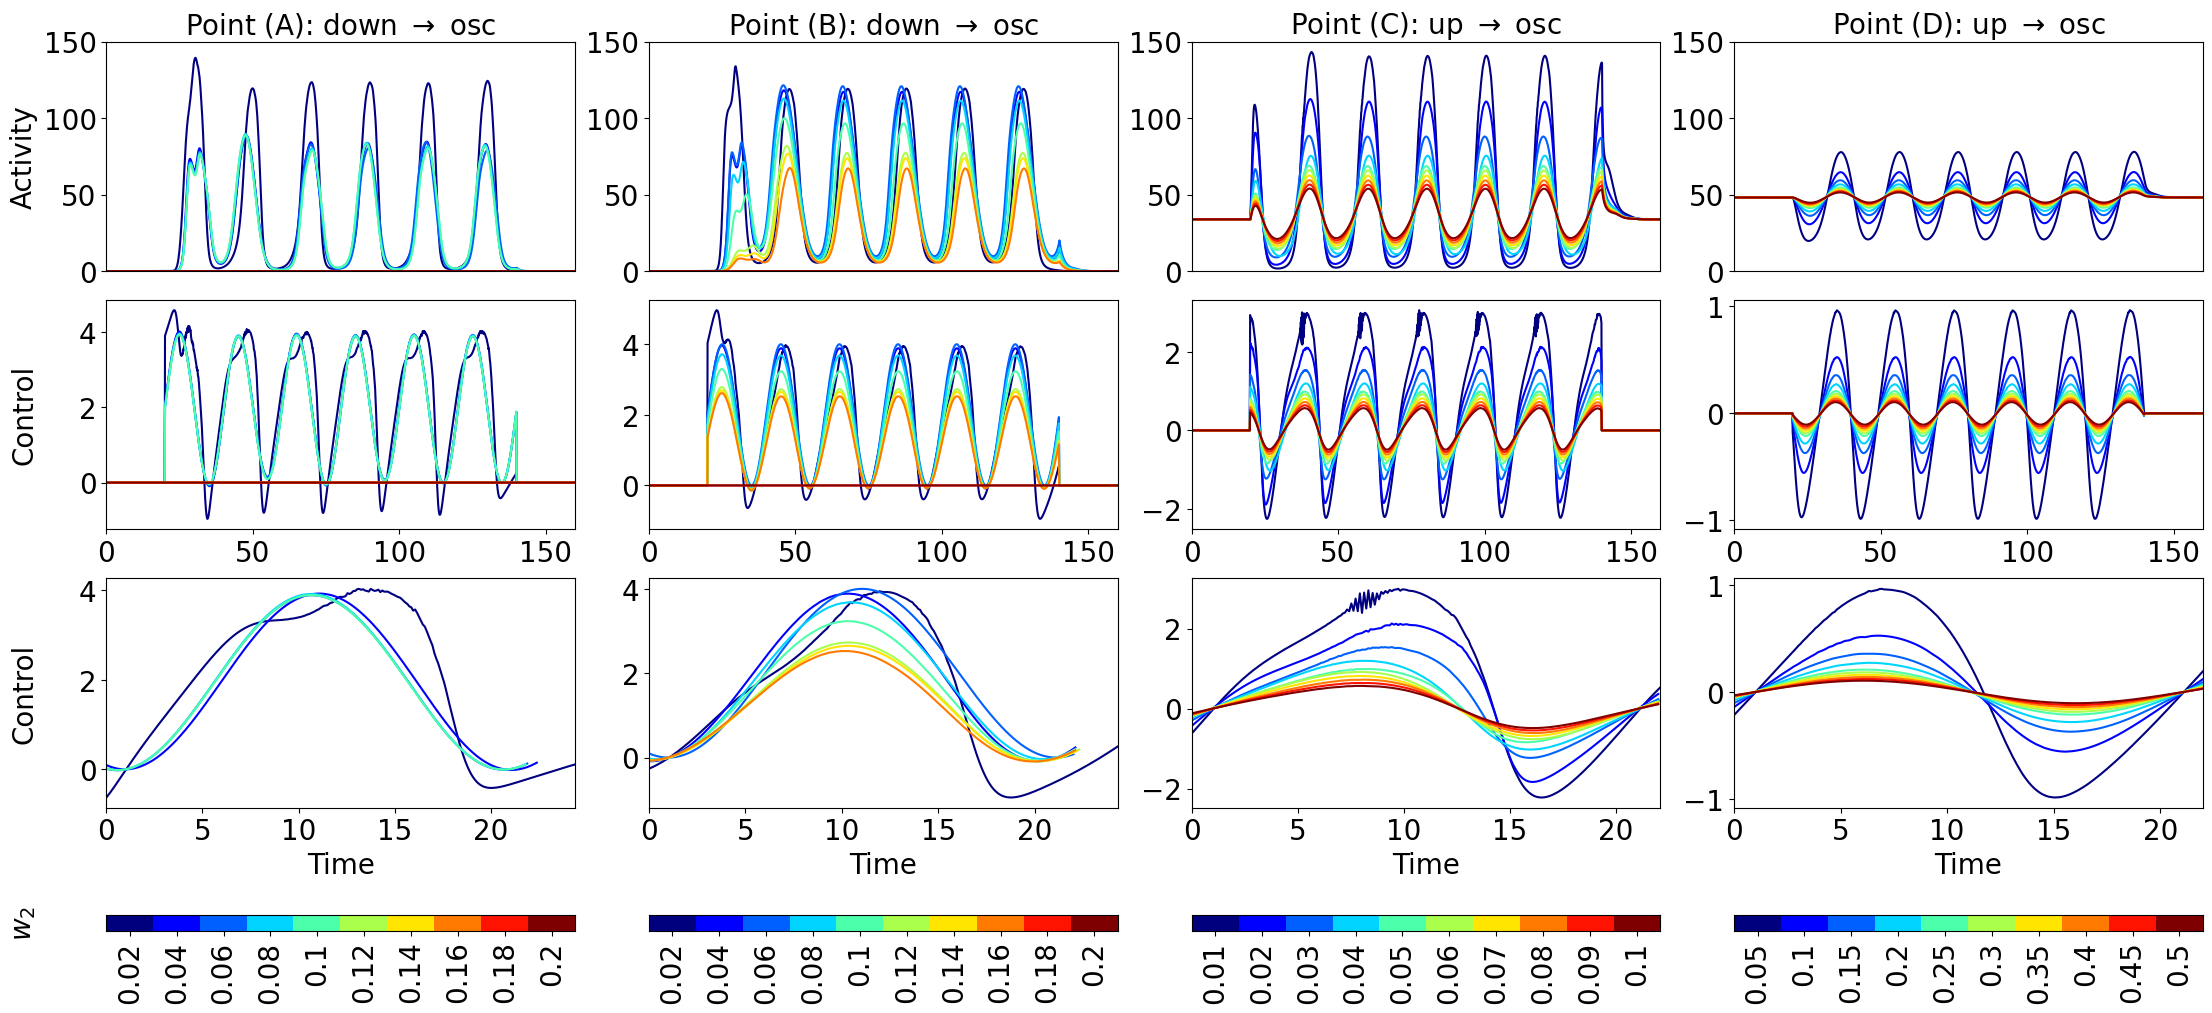

In [29]:
indzoom = np.zeros((len(p_names), len(w2_array_list[0])))
indzoom[0,:] = 4
indzoom[1,:] = 4
indzoom[2,:] = 4
indzoom[3,:] = 5
indzoom[3,0] = 6

plot_1n_osc([ data["A"]["state"], data["B"]["state"], data["C"]["state"], data["D"]["state"] ],
            [ data["A"]["control"], data["B"]["control"], data["C"]["control"], data["D"]["control"] ],
            duration, model.params.dt,
            [ data["A"]["w2"], data["B"]["w2"], data["C"]["w2"], data["D"]["w2"], ],
            indzoom, os.path.join(dir, "ALN_w2.pdf")
            )

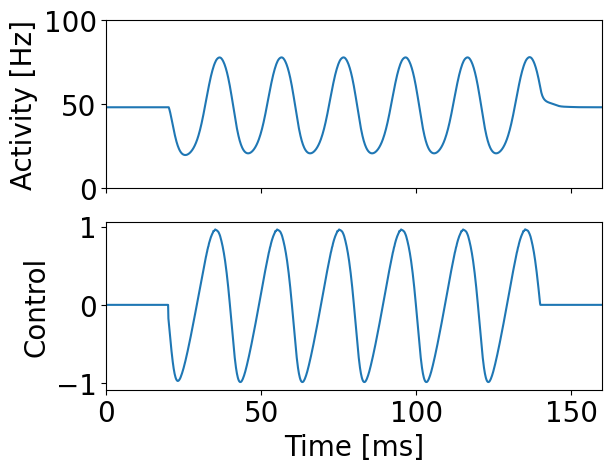

In [14]:
time = np.arange(0,160.1,0.1)

fig,ax = plt.subplots(2,1, sharex=True)

ax[0].plot(time, data["D"]["state"][0][0,0,:])
ax[1].plot(time, data["D"]["control"][0][0,0,:])

ax[0].set_xlim(time[0], time[-1])
ax[0].set_ylim(0,100)

ax[1].set_xlabel("Time")
ax[0].set_ylabel("Activity")
ax[1].set_ylabel("Control")

plt.show()

In [8]:
with open(os.path.join(pickledir, 'osc_1n_aln.pickle'), 'wb') as f:
    pickle.dump(data, f)

In [242]:
with open(os.path.join(pickledir, 'osc_1n_aln.pickle'), 'rb') as f:
    res_read = pickle.load(f)
    print(res_read.keys() )

data = res_read.copy()

dict_keys(['A', 'B', 'C', 'D'])


In [250]:
# check find_M method

for i in range(len(p_names)):
    
    p = data[p_names[i]]["coordinates"]
    print("pind = ", i, p_names[i], p)

    setinitstate(model, data[p_names[i]]["init_state"])

    model.params.duration = duration
    model.params["ext_exc_current"] = zero_control[:,0,:]
    model.params["ext_inh_current"] = zero_control[:,0,:]
    model.params.mue_ext_mean = p[0]
    model.params.mui_ext_mean = p[1]
    model.run()

    target_period = data[p_names[i]]["target_period"]
    int0 = 200
    int1 = int0 + int(target_period/dt)*6

    for iw in range(len(data[p_names[i]]["w2"])):

        w2 = data[p_names[i]]["w2"][iw]
        #print("iw = ", iw, w2)

        model_controlled = oc_aln.OcAln(model, target_period, print_array=pr,
                cost_interval=(int0,int1), control_interval=(int0, int1), cost_matrix=costmat, control_matrix=controlmat)

        p = model_controlled.find_M([0.1,1.])
        print(p)

pind =  0 A [0.0, 0.7]
Optimal control with target oscillation period
[7.47239194e-16 3.00000000e+00]
Optimal control with target oscillation period
[7.47239194e-16 3.00000000e+00]
Optimal control with target oscillation period
[7.47239194e-16 3.00000000e+00]
Optimal control with target oscillation period
[7.47239194e-16 3.00000000e+00]
Optimal control with target oscillation period
[7.47239194e-16 3.00000000e+00]
Optimal control with target oscillation period
[7.47239194e-16 3.00000000e+00]
Optimal control with target oscillation period
[7.47239194e-16 3.00000000e+00]
Optimal control with target oscillation period
[7.47239194e-16 3.00000000e+00]
Optimal control with target oscillation period
[7.47239194e-16 3.00000000e+00]
Optimal control with target oscillation period
[7.47239194e-16 3.00000000e+00]
pind =  1 B [1.0, 1.5]
Optimal control with target oscillation period
[7.47239194e-16 3.00000000e+00]
Optimal control with target oscillation period
[7.47239194e-16 3.00000000e+00]
Optima

In [11]:
def get_noisy_cost(control, M, sigma, wf, w2):

    mod = copy.deepcopy(model)

    mod.params.sigma_ou = sigma
    mod.params["ext_exc_current"] = control[:,0,:]
    mod.params["ext_inh_current"] = control[:,1,:]
    
    mod.run()
    state = getstate(mod)
    cost_f = wf * np.sum(cost_functions.fourier_cost(state, dt, data_noisy["target_period"], costmat, [int0, int1]))
    cost_2 = w2 * np.sum(cost_functions.L2_cost(control))*dt

    for m in range(1,10*M):
        mod.run()
        state_add = getstate(mod)
        cost_f_add = wf * np.sum(cost_functions.fourier_cost(state_add, dt, data_noisy["target_period"], costmat, [int0, int1]))

        cost_f += cost_f_add
        state += state_add

    return cost_2 + cost_f/(10*M), state/(10*M)

import scipy.fftpack


def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

In [8]:
data_noisy = dict()
sigma_array = [0.1, 0.3, 0.5] ### 0.1 zu schwach
M = 100
w2_n = 4

for i in range(len(p_names)):
    p = p_names[i]
    if p != "D": continue
    data_noisy = dict()
    data_noisy["coordinates"] = coords[i]
    data_noisy["target_period"] = 20.
    data_noisy["control"] = [[None for x in range(len(sigma_array))] for x1 in range(w2_n)]
    data_noisy["state"] = [[None for x in range(len(sigma_array))] for x1 in range(w2_n)]
    data_noisy["cost"] = np.zeros((w2_n, len(sigma_array)))
    data_noisy["w2"] = np.array([0.05, 0.1, 0.15, 0.2])

    data_noisy["control_det"] = data[p]["control"][1].copy()
    data_noisy["cost_det"] = np.zeros((w2_n, len(sigma_array)))
    data_noisy["state_det"] = [[None for x in range(len(sigma_array))] for x1 in range(w2_n)]

    data_noisy["control_det_opt"] = [[data[p]["control"][1].copy() for x in range(len(sigma_array))] for x1 in range(w2_n)]
    data_noisy["cost_det_opt"] = np.zeros((w2_n, len(sigma_array)))
    data_noisy["state_det_opt"] = [[None for x in range(len(sigma_array))] for x1 in range(w2_n)]

    data_noisy["state_det_opt_det"] = [[None for x in range(len(sigma_array))] for x1 in range(w2_n)]

In [9]:
it = 100

p = data_noisy["coordinates"]
pr = np.arange(0,101,10)

target_period = data_noisy["target_period"]
int0 = 200
int1 = int0 + int(target_period/dt)*6

In [486]:
wind = 0

for si in range(len(sigma_array)):
    
    print("SIGMA = ", sigma_array[si])
    w2 = data_noisy["w2"][wind]

    model.params.sigma_ou = sigma_array[si]
    model.params.duration = duration
    setinitstate(model, data["D"]["init_state"])

    model.params["ext_exc_current"] = zero_control[:,0,:]
    model.params["ext_inh_current"] = zero_control[:,0,:]
    model.params.mue_ext_mean = p[0]
    model.params.mui_ext_mean = p[1]
    model.run()
    
    if True:

        model_controlled = oc_aln.OcAln(model, target_period, print_array=pr, cost_interval=(int0,int1), control_interval=(int0, int1),
                                        cost_matrix=costmat, control_matrix=controlmat, M=M, M_validation=M*10, validate_per_step=False,
        )
        model_controlled.weights["w_p"] = 0.
        model_controlled.weights["w_2"] = w2
        model_controlled.weights["w_f"] = 1.

        model_controlled.maximum_control_strength = maxstr

        if False:
            if type(data_noisy["control"][wind][si]) != type(None):
                model_controlled.control = data_noisy["control"][wind][si].copy()
                model_controlled.update_input()

        for l in range(1):
            for k in range(-6,7,3):
                model_controlled.step = 10.**k
                model_controlled.optimize(it)
                model_controlled.zero_step_encountered = False
                model_controlled.control[0,0,:] = smooth(model_controlled.control.copy()[0,0,:], 2)
                model_controlled.update_input()

                #print(l, k)
                #plt.plot(model_controlled.control[0,0,:])
                #plt.plot(model_controlled.gradient[0,0,:])
                #plt.show()

        data_noisy["control"][wind][si] = model_controlled.control.copy()
        data_noisy["cost"][wind][si] = model_controlled.cost_validation

        meanstate = model_controlled.get_xs()
        for m in range(M-1):
            model_controlled.model.run()
            meanstate += model_controlled.get_xs()
        data_noisy["state"][wind][si] = meanstate / M
    
    #################################################
    data_noisy["cost_det"][wind][si], data_noisy["state_det"][wind][si] = get_noisy_cost(data_noisy["control_det"], M, sigma_array[si], model_controlled.weights["w_f"], model_controlled.weights["w_2"])
    print("cost det = ", data_noisy["cost_det"][wind][si])

    #################################################

    if True:

        model_controlled = oc_aln.OcAln(model, target_period, print_array=pr, cost_interval=(int0,int1), control_interval=(int0, int1),
                                        cost_matrix=costmat, control_matrix=controlmat, M=M, M_validation=M*10, validate_per_step=False,
        )

        model_controlled.weights["w_p"] = 0.
        model_controlled.weights["w_2"] = w2
        model_controlled.weights["w_f"] = 1.
        model_controlled.maximum_control_strength = maxstr

        model_controlled.control = data_noisy["control_det"].copy()

        if False:
            if type(data_noisy["control_det_opt"][wind][si]) != type(None):
                model_controlled.control = data_noisy["control_det_opt"][wind][si].copy()
        
        model_controlled.update_input()
        
        for l in range(1):
            for k in range(-6,7,3):
                model_controlled.step = 10.**k
                model_controlled.optimize(it)
                model_controlled.zero_step_encountered = False
                model_controlled.control[0,0,:] = smooth(model_controlled.control.copy()[0,0,:], 2)
                model_controlled.update_input()

                #print(l, k)
                #plt.plot(model_controlled.control[0,0,:])
                #plt.plot(model_controlled.gradient[0,0,:])
                #plt.show()

        data_noisy["control_det_opt"][wind][si] = model_controlled.control.copy()
        data_noisy["cost_det_opt"][wind][si] = model_controlled.cost_validation

        model_controlled.update_input()

        meanstate = model_controlled.get_xs()
        for m in range(M-1):
            model_controlled.model.run()
            meanstate += model_controlled.get_xs()
        data_noisy["state_det_opt"][wind][si] = meanstate / M
        plt.show()

    if True:
        model.params.sigma_ou = 0.
        model.params.duration = duration
        model.params.mue_ext_mean = p[0]
        model.params.mui_ext_mean = p[1]
        setinitstate(model, data["D"]["init_state"])

        model.params["ext_exc_current"] = data_noisy["control_det_opt"][wind][si][:,0,:]
        model.params["ext_inh_current"] = data_noisy["control_det_opt"][wind][si][:,1,:]

        model.run()
        data_noisy["state_det_opt_det"][wind][si] = getstate(model)

    with open(os.path.join(pickledir, 'osc_1n_aln_noisy.pickle'), 'wb') as f:
        pickle.dump(data_noisy, f)

SIGMA =  0.1
Optimal control with target oscillation period
Compute control for a noisy system
Mean cost in iteration 0: -1.383320505045396
Mean cost in iteration 10: -1.4137299112013257
Mean cost in iteration 20: -1.4547935016961326
Mean cost in iteration 30: -1.3118509811045842
Mean cost in iteration 40: -1.3545845054028722
Mean cost in iteration 50: -1.4375477598509478
Mean cost in iteration 60: -1.5148116178779554
Mean cost in iteration 70: -1.5471565039335724
Mean cost in iteration 80: -1.4228553300375397
Mean cost in iteration 90: -1.4682742735808452
Mean cost in iteration 100: -1.4570639309930442
Minimal cost found at iteration 35
Final cost validated with 1000 noise realizations : -1.4230660549035161
Compute control for a noisy system
Mean cost in iteration 0: -1.4474328986422256
Mean cost in iteration 10: -1.3630561231143923
Mean cost in iteration 20: -1.6083071008444636
Mean cost in iteration 30: -1.4057223879972827
Mean cost in iteration 40: -1.4747479480406764
Mean cost in 

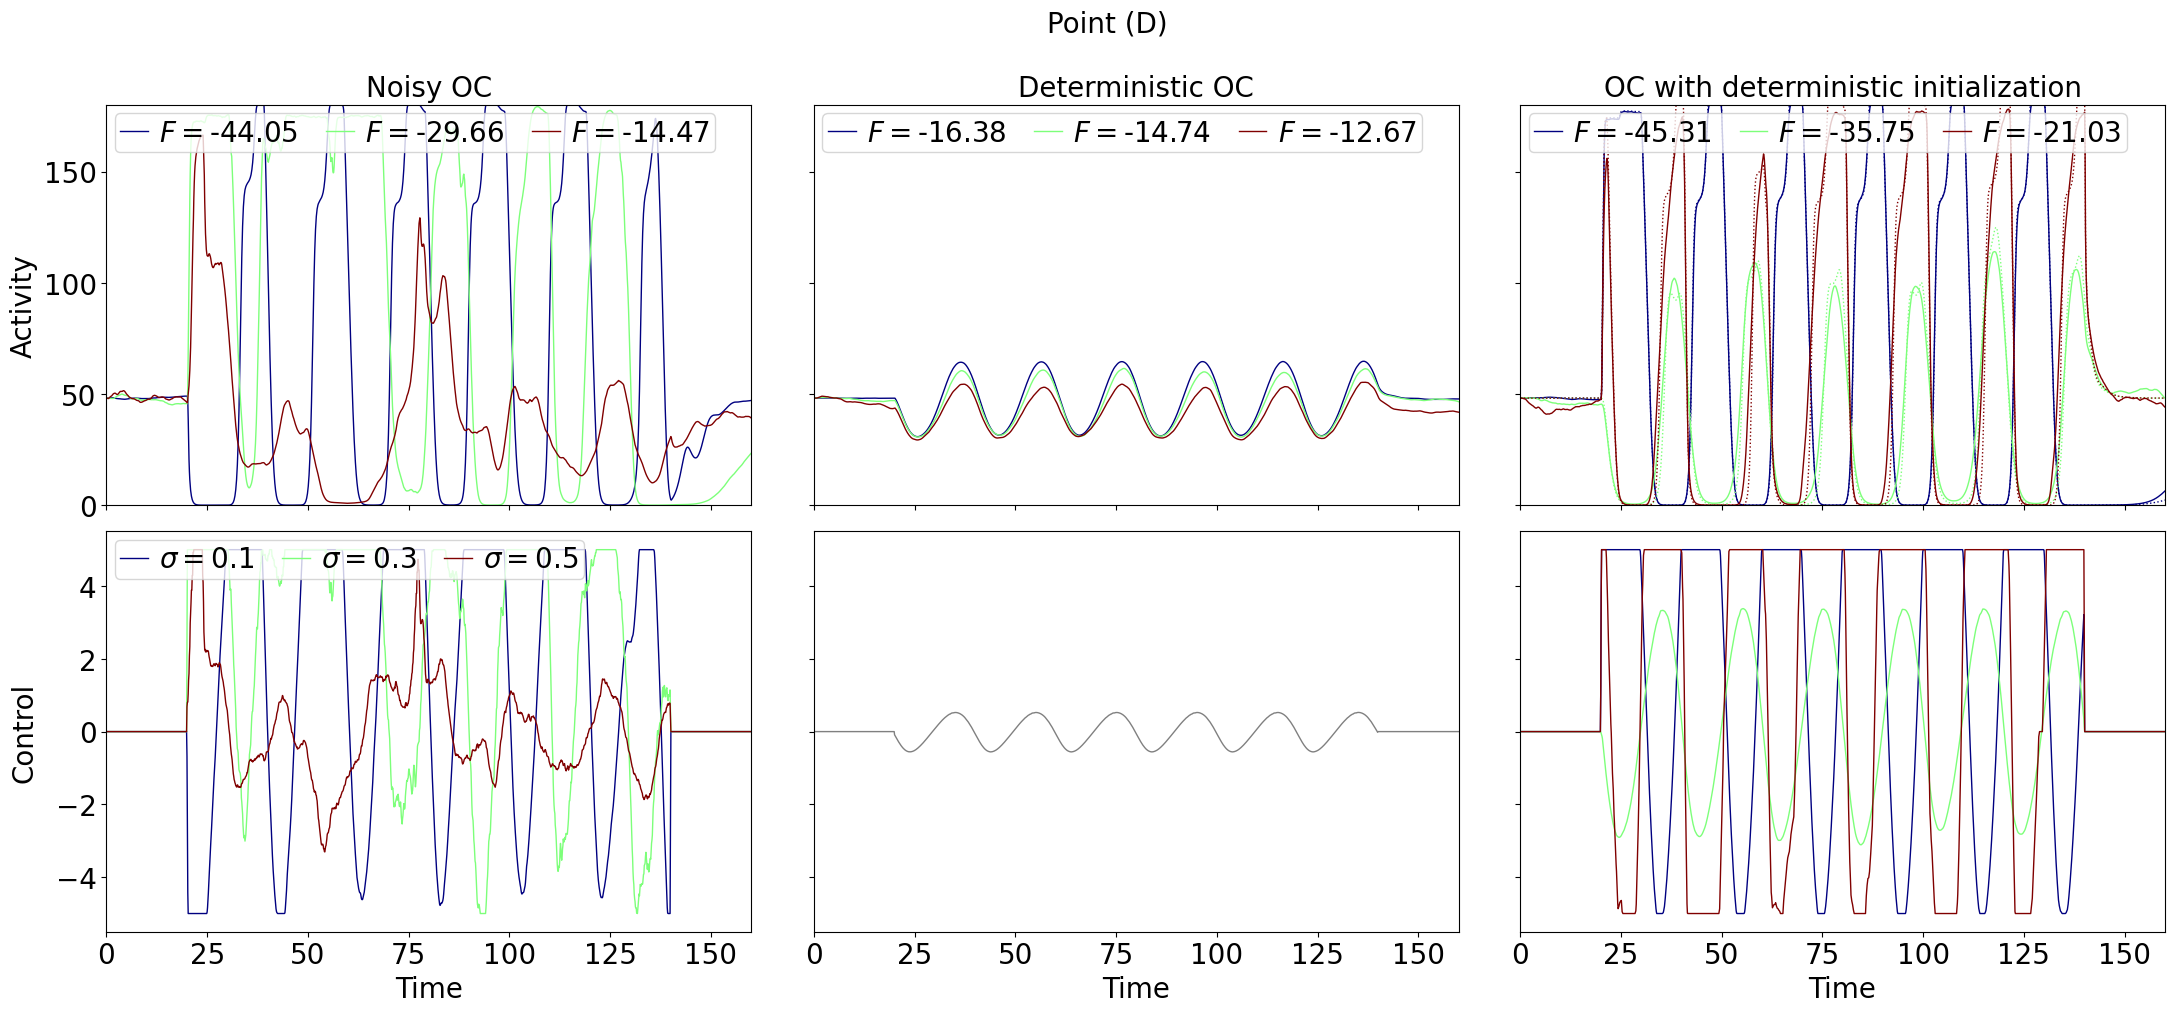

-44.052 & -29.659 & -14.473 & -16.377 & -14.745 & -12.669 & -45.314 & -35.754 & -21.034 \\


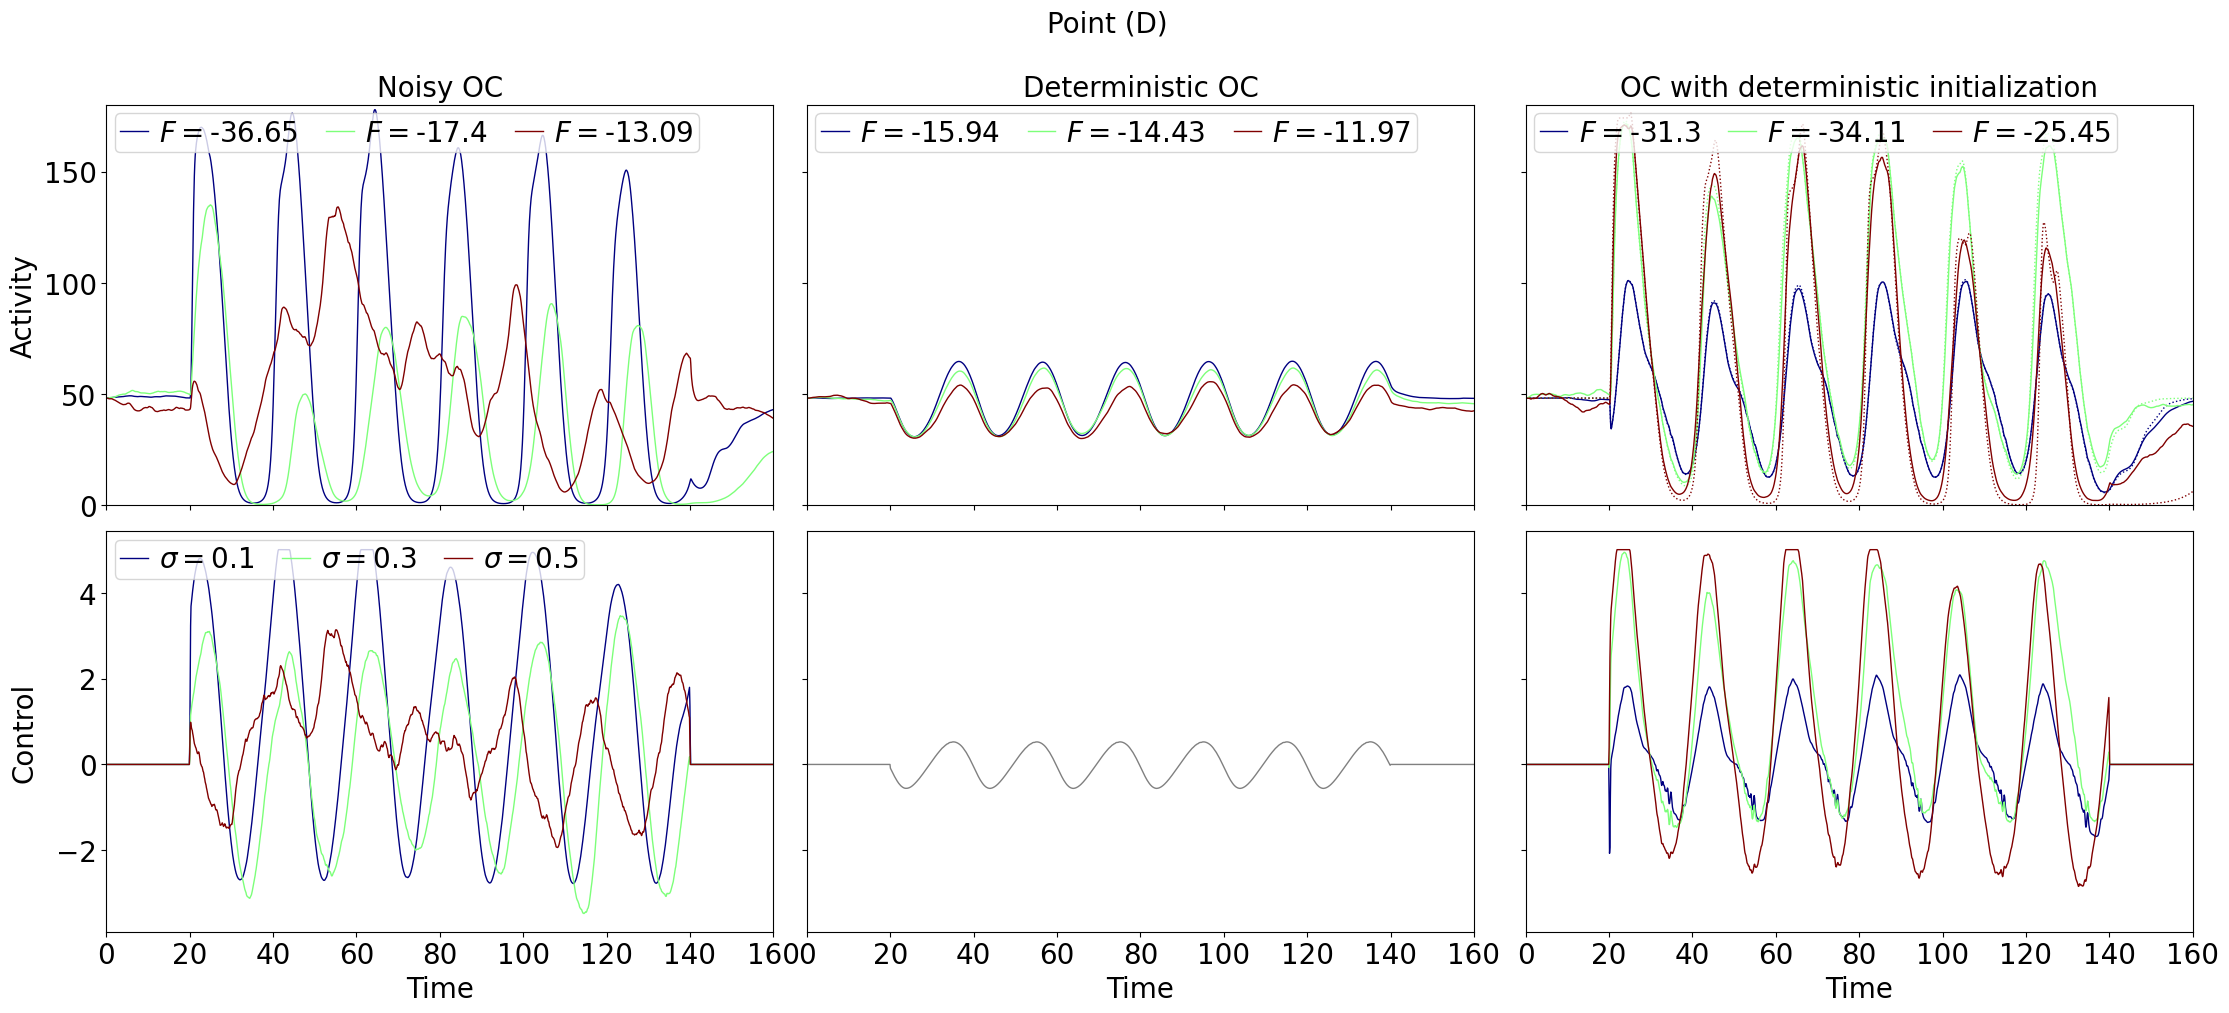

-36.654 & -17.398 & -13.09 & -15.935 & -14.433 & -11.974 & -31.3 & -34.11 & -25.448 \\


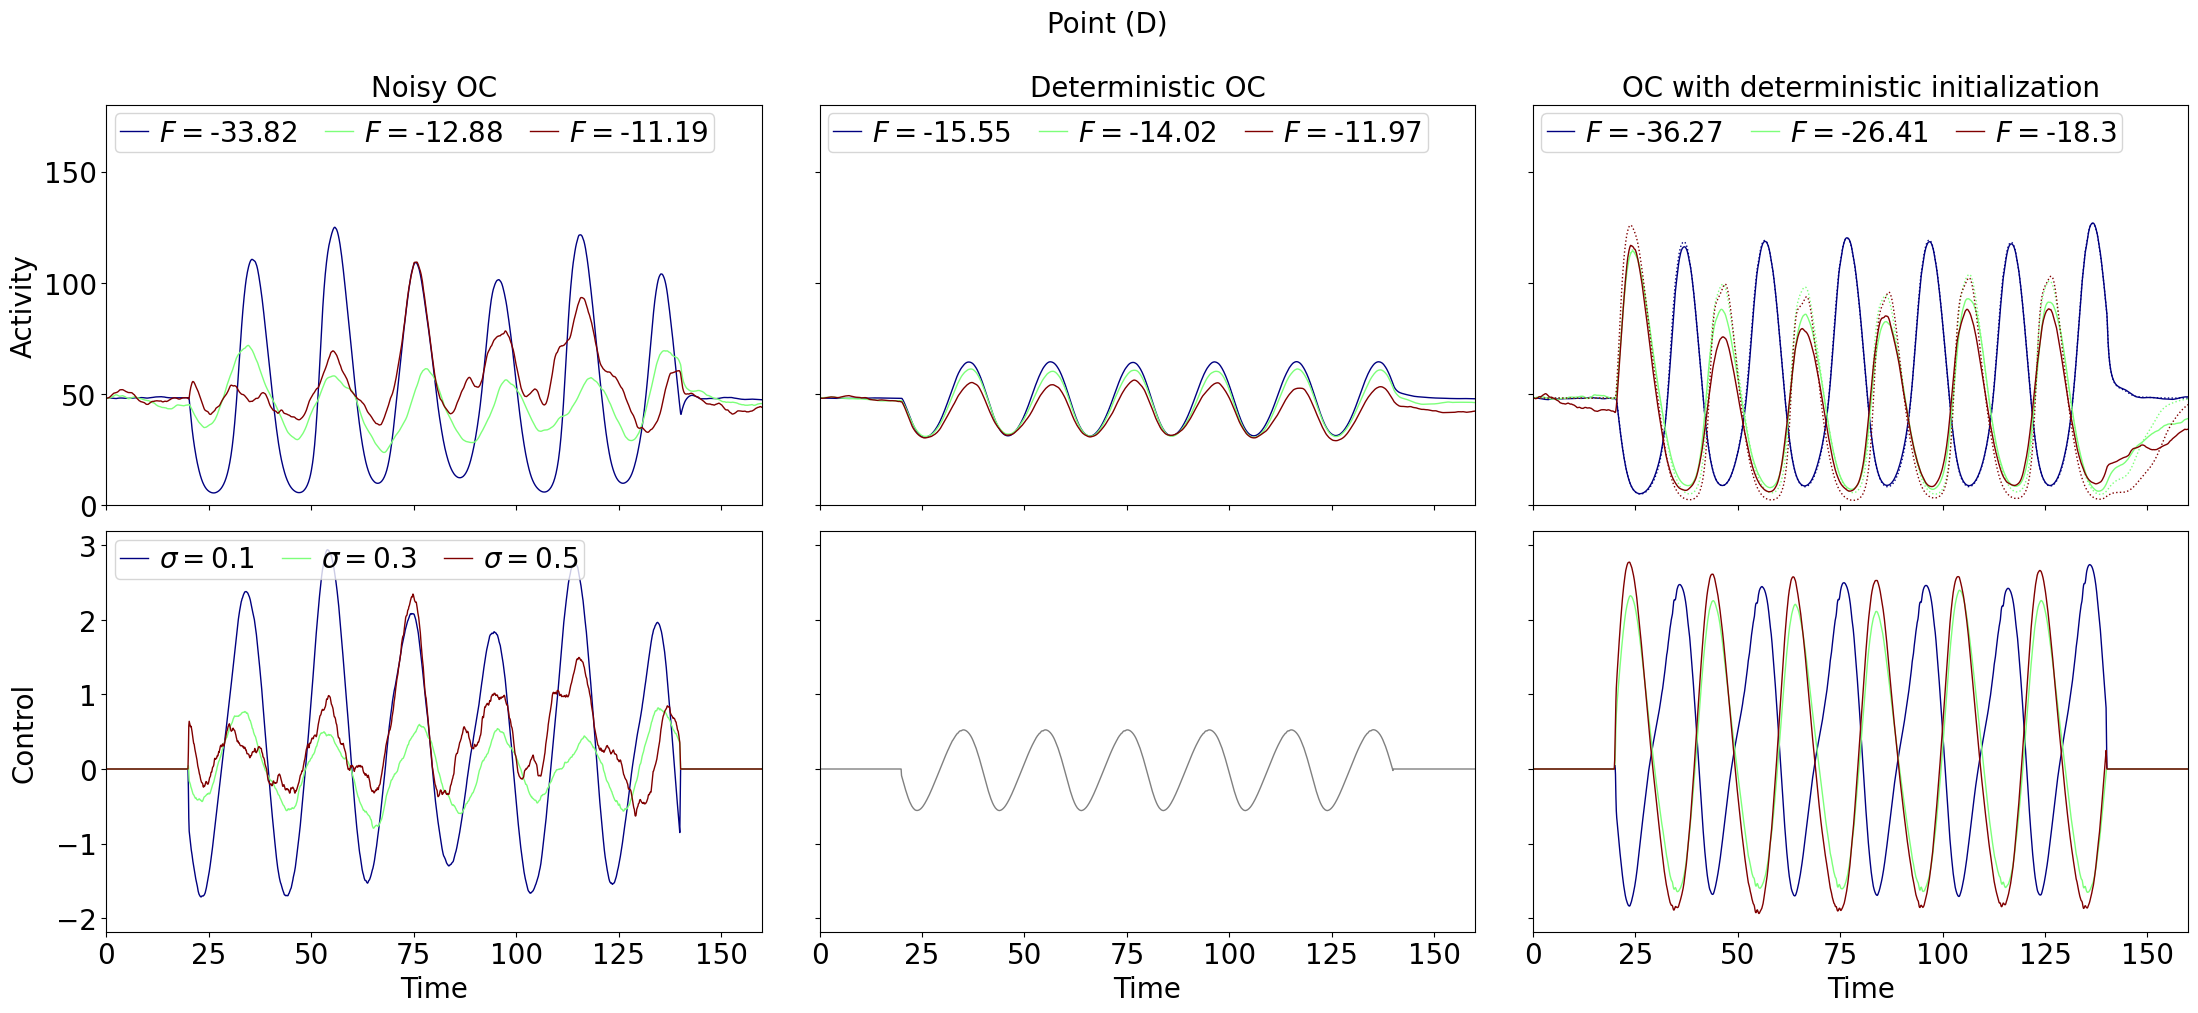

-33.82 & -12.879 & -11.189 & -15.551 & -14.021 & -11.972 & -36.269 & -26.414 & -18.299 \\


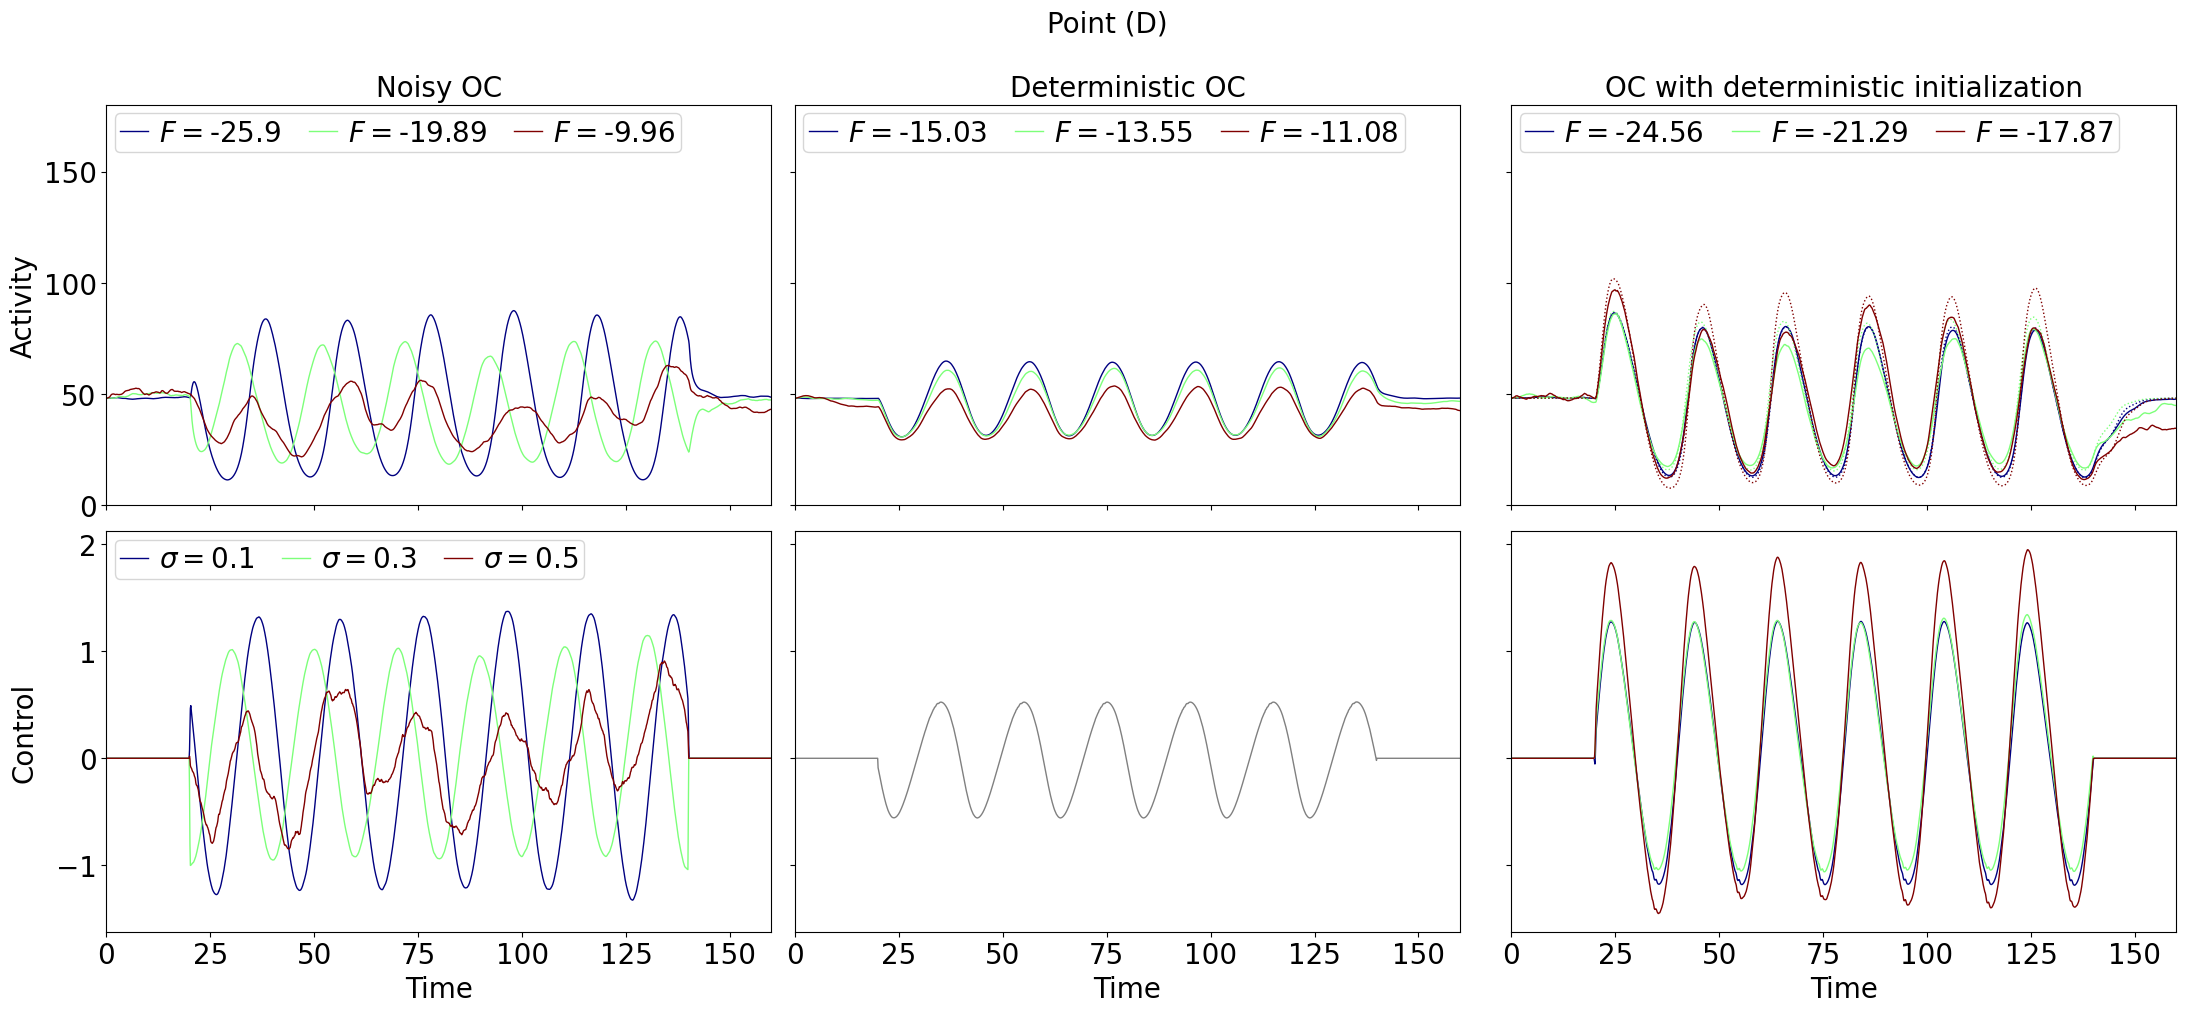

-25.898 & -19.887 & -9.963 & -15.035 & -13.554 & -11.081 & -24.564 & -21.289 & -17.872 \\


In [16]:
for wind in range(w2_n):

        #if wind not in [0]: continue

        plot_1n_osc_noisy(
                data_noisy["state"][wind], data_noisy["control"][wind], data_noisy["cost"][wind],
                data_noisy["state_det"][wind], data_noisy["control_det"], data_noisy["cost_det"][wind],
                data_noisy["state_det_opt"][wind], data_noisy["control_det_opt"][wind], data_noisy["cost_det_opt"][wind],
                data["D"]["state"][1], data_noisy["state_det_opt_det"][wind],
                duration, dt, sigma_array,  M, os.path.join(dir, "ALN_w2_noisy" + str(wind) + ".pdf"))

        tablestring = ""
        for si in range(len(sigma_array)):
                tablestring = tablestring + str(np.around(data_noisy["cost"][wind][si],3)) + " & "
        for si in range(len(sigma_array)):
                tablestring = tablestring + str(np.around(data_noisy["cost_det"][wind][si],3)) + " & "
        for si in range(len(sigma_array)):
                tablestring = tablestring + str(np.around(data_noisy["cost_det_opt"][wind][si],3)) + " & "
        tablestring = tablestring[:-3]
        tablestring = tablestring + " \\" + "\\"

        print(tablestring)

In [20]:
it = 100

for wind in range(1, w2_n):

        if wind != 1: continue

        for si in range(len(sigma_array)):

                if si not in [0]: continue
        
                print("SIGMA = ", sigma_array[si])
                w2 = data_noisy["w2"][wind]

                model.params.sigma_ou = sigma_array[si]
                model.params.duration = duration
                setinitstate(model, data["D"]["init_state"])

                model.params["ext_exc_current"] = zero_control[:,0,:]
                model.params["ext_inh_current"] = zero_control[:,0,:]
                model.params.mue_ext_mean = p[0]
                model.params.mui_ext_mean = p[1]
                model.run()

                if False:

                        model_controlled = oc_aln.OcAln(model, target_period, print_array=pr, cost_interval=(int0,int1), control_interval=(int0, int1),
                                                        cost_matrix=costmat, control_matrix=controlmat, M=M, M_validation=M*10, validate_per_step=False,
                        )
                        model_controlled.weights["w_p"] = 0.
                        model_controlled.weights["w_2"] = w2
                        model_controlled.weights["w_f"] = 1.

                        model_controlled.maximum_control_strength = maxstr

                        if False:
                                if type(data_noisy["control"][wind][si]) != type(None):
                                        model_controlled.control = data_noisy["control"][wind][si].copy()
                                        model_controlled.update_input()

                        for k in range(-6,7,3):
                                model_controlled.step = 10.**k
                                model_controlled.optimize(it)
                                model_controlled.zero_step_encountered = False
                                model_controlled.control[0,0,:] = smooth(model_controlled.control.copy()[0,0,:], 2)
                                model_controlled.update_input()

                        data_noisy["control"][wind][si] = model_controlled.control.copy()
                        data_noisy["cost"][wind][si] = model_controlled.cost_validation

                        meanstate = model_controlled.get_xs()
                        for m in range(M-1):
                                model_controlled.model.run()
                                meanstate += model_controlled.get_xs()
                        data_noisy["state"][wind][si] = meanstate / M
                
                #################################################
                if False:
                        data_noisy["cost_det"][wind][si], data_noisy["state_det"][wind][si] = get_noisy_cost(data_noisy["control_det"], M, sigma_array[si], model_controlled.weights["w_f"], model_controlled.weights["w_2"])
                        print("cost det = ", data_noisy["cost_det"][wind][si])

                #################################################

                if True:

                        model_controlled = oc_aln.OcAln(model, target_period, print_array=pr, cost_interval=(int0,int1), control_interval=(int0, int1),
                                                        cost_matrix=costmat, control_matrix=controlmat, M=M, M_validation=M*10, validate_per_step=False,
                        )

                        model_controlled.weights["w_p"] = 0.
                        model_controlled.weights["w_2"] = w2
                        model_controlled.weights["w_f"] = 1.
                        model_controlled.maximum_control_strength = maxstr

                        model_controlled.control = data_noisy["control_det"].copy()

                        if False:
                                if type(data_noisy["control_det_opt"][wind][si]) != type(None):
                                        model_controlled.control = data_noisy["control_det_opt"][wind][si].copy()
                        
                        model_controlled.update_input()
                        
                        for k in range(-6,7,3):
                                model_controlled.step = 10.**k
                                model_controlled.optimize(it)
                                model_controlled.zero_step_encountered = False
                                model_controlled.control[0,0,:] = smooth(model_controlled.control.copy()[0,0,:], 2)
                                model_controlled.update_input()

                        data_noisy["control_det_opt"][wind][si] = model_controlled.control.copy()
                        data_noisy["cost_det_opt"][wind][si] = model_controlled.cost_validation

                        model_controlled.update_input()

                        meanstate = model_controlled.get_xs()
                        for m in range(M-1):
                                model_controlled.model.run()
                                meanstate += model_controlled.get_xs()
                        data_noisy["state_det_opt"][wind][si] = meanstate / M

                if True:
                        model.params.sigma_ou = 0.
                        model.params.duration = duration
                        model.params.mue_ext_mean = p[0]
                        model.params.mui_ext_mean = p[1]
                        setinitstate(model, data["D"]["init_state"])

                        model.params["ext_exc_current"] = data_noisy["control_det_opt"][wind][si][:,0,:]
                        model.params["ext_inh_current"] = data_noisy["control_det_opt"][wind][si][:,1,:]

                        model.run()
                        data_noisy["state_det_opt_det"][wind][si] = getstate(model)

                with open(os.path.join(pickledir, 'osc_1n_aln_noisy.pickle'), 'wb') as f:
                        pickle.dump(data_noisy, f)

SIGMA =  0.1
Optimal control with target oscillation period
Compute control for a noisy system
Mean cost in iteration 0: -15.899324602893289
Mean cost in iteration 10: -16.017844833791308
Mean cost in iteration 20: -16.001273572448753
Mean cost in iteration 30: -15.923564441063242
Mean cost in iteration 40: -15.939848206837588
Mean cost in iteration 50: -15.742436871432208
Mean cost in iteration 60: -15.927921286871774
Mean cost in iteration 70: -15.951498001014208
Mean cost in iteration 80: -15.911286064837725
Mean cost in iteration 90: -15.827736157774178
Mean cost in iteration 100: -16.013989604207694
Minimal cost found at iteration 57
Final cost validated with 1000 noise realizations : -15.880663344332053
Compute control for a noisy system
Mean cost in iteration 0: -16.022631153249584
Mean cost in iteration 10: -16.131538338753238
Mean cost in iteration 20: -15.88252587370198
Mean cost in iteration 30: -15.88264587240461
Mean cost in iteration 40: -15.834583187868166
Mean cost in i

In [7]:
with open(os.path.join(pickledir, 'osc_1n_aln_noisy.pickle'), 'rb') as f:
    res_read = pickle.load(f)
    print(res_read.keys() )

data_noisy = res_read.copy()

dict_keys(['coordinates', 'target_period', 'control', 'state', 'cost', 'w2', 'control_det', 'cost_det', 'state_det', 'control_det_opt', 'cost_det_opt', 'state_det_opt', 'state_det_opt_det'])


In [8]:
data_noisy_10 = dict()
sigma_array = [0.1, 0.3, 0.5] ### 0.1 zu schwach
M = 10
w2_n = 4

for i in range(len(p_names)):
    p = p_names[i]
    if p != "D": continue
    data_noisy_10 = dict()
    data_noisy_10["coordinates"] = coords[i]
    data_noisy_10["target_period"] = 20.
    data_noisy_10["control"] = [[None for x in range(len(sigma_array))] for x1 in range(w2_n)]
    data_noisy_10["state"] = [[None for x in range(len(sigma_array))] for x1 in range(w2_n)]
    data_noisy_10["cost"] = np.zeros((w2_n, len(sigma_array)))
    data_noisy_10["w2"] = np.array([0.05, 0.1, 0.15, 0.2])

    data_noisy_10["control_det"] = data[p]["control"][1].copy()
    data_noisy_10["cost_det"] = np.zeros((w2_n, len(sigma_array)))
    data_noisy_10["state_det"] = [[None for x in range(len(sigma_array))] for x1 in range(w2_n)]

    data_noisy_10["control_det_opt"] = [[data[p]["control"][1].copy() for x in range(len(sigma_array))] for x1 in range(w2_n)]
    data_noisy_10["cost_det_opt"] = np.zeros((w2_n, len(sigma_array)))
    data_noisy_10["state_det_opt"] = [[None for x in range(len(sigma_array))] for x1 in range(w2_n)]

    data_noisy_10["state_det_opt_det"] = [[None for x in range(len(sigma_array))] for x1 in range(w2_n)]

it = 100

p = data_noisy["coordinates"]
pr = np.arange(0,101,10)

target_period = data_noisy_10["target_period"]
int0 = 200
int1 = int0 + int(target_period/dt)*6

In [13]:
for wind in range(w2_n):

    #if wind != 1: continue

    for si in range(len(sigma_array)):

        if si not in [1,2]: continue

        print("SIGMA = ", sigma_array[si])
        w2 = data_noisy_10["w2"][wind]

        model.params.sigma_ou = sigma_array[si]
        model.params.duration = duration
        setinitstate(model, data["D"]["init_state"])

        model.params["ext_exc_current"] = zero_control[:,0,:]
        model.params["ext_inh_current"] = zero_control[:,0,:]
        model.params.mue_ext_mean = p[0]
        model.params.mui_ext_mean = p[1]
        model.run()

        if True:

            model_controlled = oc_aln.OcAln(model, target_period, print_array=pr, cost_interval=(int0,int1), control_interval=(int0, int1),
                                            cost_matrix=costmat, control_matrix=controlmat, M=M, M_validation=M*10, validate_per_step=False,
            )
            model_controlled.weights["w_p"] = 0.
            model_controlled.weights["w_2"] = w2
            model_controlled.weights["w_f"] = 1.

            model_controlled.maximum_control_strength = maxstr


            for k in range(-6,7,3):
                    model_controlled.step = 10.**k
                    model_controlled.optimize(it)
                    model_controlled.zero_step_encountered = False
                    #model_controlled.control[0,0,:] = smooth(model_controlled.control.copy()[0,0,:], 2)
                    #model_controlled.update_input()

            data_noisy_10["control"][wind][si] = model_controlled.control.copy()
            data_noisy_10["cost"][wind][si] = model_controlled.cost_validation

            meanstate = model_controlled.get_xs()
            for m in range(M-1):
                    model_controlled.model.run()
                    meanstate += model_controlled.get_xs()
            data_noisy_10["state"][wind][si] = meanstate / M
    
        #################################################
        if True:
            data_noisy_10["cost_det"][wind][si], data_noisy_10["state_det"][wind][si] = get_noisy_cost(data_noisy_10["control_det"], M, sigma_array[si], model_controlled.weights["w_f"], model_controlled.weights["w_2"])
            print("cost det = ", data_noisy_10["cost_det"][wind][si])

        #################################################

        if True:

            model_controlled = oc_aln.OcAln(model, target_period, print_array=pr, cost_interval=(int0,int1), control_interval=(int0, int1),
                                            cost_matrix=costmat, control_matrix=controlmat, M=M, M_validation=M*10, validate_per_step=False,
            )

            model_controlled.weights["w_p"] = 0.
            model_controlled.weights["w_2"] = w2
            model_controlled.weights["w_f"] = 1.
            model_controlled.maximum_control_strength = maxstr

            model_controlled.control = data_noisy_10["control_det"].copy()
            
            model_controlled.update_input()
            
            for k in range(-6,7,3):
                    model_controlled.step = 10.**k
                    model_controlled.optimize(it)
                    model_controlled.zero_step_encountered = False

            data_noisy_10["control_det_opt"][wind][si] = model_controlled.control.copy()
            data_noisy_10["cost_det_opt"][wind][si] = model_controlled.cost_validation

            model_controlled.update_input()

            meanstate = model_controlled.get_xs()
            for m in range(M-1):
                    model_controlled.model.run()
                    meanstate += model_controlled.get_xs()
            data_noisy_10["state_det_opt"][wind][si] = meanstate / M

        if True:
            model.params.sigma_ou = 0.
            model.params.duration = duration
            model.params.mue_ext_mean = p[0]
            model.params.mui_ext_mean = p[1]
            setinitstate(model, data["D"]["init_state"])

            model.params["ext_exc_current"] = data_noisy_10["control_det_opt"][wind][si][:,0,:]
            model.params["ext_inh_current"] = data_noisy_10["control_det_opt"][wind][si][:,1,:]

            model.run()
            data_noisy_10["state_det_opt_det"][wind][si] = getstate(model)

        with open(os.path.join(pickledir, 'osc_1n_aln_noisy_10.pickle'), 'wb') as f:
                pickle.dump(data_noisy_10, f)

SIGMA =  0.3
Optimal control with target oscillation period
Compute control for a noisy system
Mean cost in iteration 0: -3.6841265637084595
Mean cost in iteration 10: -3.1458875945821907
Mean cost in iteration 20: -4.216962131438075
Mean cost in iteration 30: -2.8361534895578853
Mean cost in iteration 40: -3.657457310034066
Mean cost in iteration 50: -3.331680414008553
Mean cost in iteration 60: -4.024224297194628
Mean cost in iteration 70: -2.972576951361312
Mean cost in iteration 80: -3.4457119573713926
Mean cost in iteration 90: -3.6844057894717586
Mean cost in iteration 100: -4.219348905850182
Minimal cost found at iteration 16
Final cost validated with 100 noise realizations : -3.9680327397851487
Compute control for a noisy system
Mean cost in iteration 0: -4.109242520539317
Mean cost in iteration 10: -4.034942667081543
Mean cost in iteration 20: -3.6519722007499595
Mean cost in iteration 30: -4.27917909023997
Mean cost in iteration 40: -3.2010331103945076
Mean cost in iteration 

In [16]:
for wind in range(w2_n):

    tablestring = ""
    tablestring = tablestring + str(data_noisy_10["w2"][wind]) + " & "
    for si in range(len(sigma_array)):
        tablestring = tablestring + str(np.around(data_noisy_10["cost"][wind][si],3)) + " & "
    tablestring = tablestring + "\hspace{10pt} "
    for si in range(len(sigma_array)):
        tablestring = tablestring + str(np.around(data_noisy_10["cost_det"][wind][si],3)) + " & "
    tablestring = tablestring + "\hspace{10pt} "
    for si in range(len(sigma_array)):
        tablestring = tablestring + str(np.around(data_noisy_10["cost_det_opt"][wind][si],3)) + " & "
    tablestring = tablestring[:-3]
    tablestring = tablestring + " \\" + "\\"

    print(tablestring)

0.05 & -47.02 & -24.57 & -24.465 & \hspace{10pt} -16.376 & -14.98 & -13.339 & \hspace{10pt} -46.422 & -38.489 & -32.145 \\
0.1 & -35.796 & -6.115 & -8.409 & \hspace{10pt} -15.863 & -15.029 & -12.285 & \hspace{10pt} -24.308 & -21.724 & -14.912 \\
0.15 & -35.204 & -17.069 & -10.054 & \hspace{10pt} -15.588 & -13.886 & -11.049 & \hspace{10pt} -33.894 & -22.515 & -17.186 \\
0.2 & -25.262 & -6.018 & -3.562 & \hspace{10pt} -14.8 & -13.984 & -10.532 & \hspace{10pt} -24.548 & -19.229 & -15.443 \\


In [20]:
data_noisy_30 = dict()
sigma_array = [0.1, 0.3, 0.5] ### 0.1 zu schwach
M = 30
w2_n = 4

for i in range(len(p_names)):
    p = p_names[i]
    if p != "D": continue
    data_noisy_30 = dict()
    data_noisy_30["coordinates"] = coords[i]
    data_noisy_30["target_period"] = 20.
    data_noisy_30["control"] = [[None for x in range(len(sigma_array))] for x1 in range(w2_n)]
    data_noisy_30["state"] = [[None for x in range(len(sigma_array))] for x1 in range(w2_n)]
    data_noisy_30["cost"] = np.zeros((w2_n, len(sigma_array)))
    data_noisy_30["w2"] = np.array([0.05, 0.1, 0.15, 0.2])

    data_noisy_30["control_det"] = data[p]["control"][1].copy()
    data_noisy_30["cost_det"] = np.zeros((w2_n, len(sigma_array)))
    data_noisy_30["state_det"] = [[None for x in range(len(sigma_array))] for x1 in range(w2_n)]

    data_noisy_30["control_det_opt"] = [[data[p]["control"][1].copy() for x in range(len(sigma_array))] for x1 in range(w2_n)]
    data_noisy_30["cost_det_opt"] = np.zeros((w2_n, len(sigma_array)))
    data_noisy_30["state_det_opt"] = [[None for x in range(len(sigma_array))] for x1 in range(w2_n)]

    data_noisy_30["state_det_opt_det"] = [[None for x in range(len(sigma_array))] for x1 in range(w2_n)]

it = 100

p = data_noisy["coordinates"]
pr = np.arange(0,101,10)

target_period = data_noisy_30["target_period"]
int0 = 200
int1 = int0 + int(target_period/dt)*6

In [21]:
for wind in range(w2_n):

    #if wind != 1: continue

    for si in range(len(sigma_array)):

        print("SIGMA = ", sigma_array[si])
        w2 = data_noisy_30["w2"][wind]

        model.params.sigma_ou = sigma_array[si]
        model.params.duration = duration
        setinitstate(model, data["D"]["init_state"])

        model.params["ext_exc_current"] = zero_control[:,0,:]
        model.params["ext_inh_current"] = zero_control[:,0,:]
        model.params.mue_ext_mean = p[0]
        model.params.mui_ext_mean = p[1]
        model.run()

        if True:

            model_controlled = oc_aln.OcAln(model, target_period, print_array=pr, cost_interval=(int0,int1), control_interval=(int0, int1),
                                            cost_matrix=costmat, control_matrix=controlmat, M=M, M_validation=M*10, validate_per_step=False,
            )
            model_controlled.weights["w_p"] = 0.
            model_controlled.weights["w_2"] = w2
            model_controlled.weights["w_f"] = 1.

            model_controlled.maximum_control_strength = maxstr


            for k in range(-6,7,3):
                    model_controlled.step = 10.**k
                    model_controlled.optimize(it)
                    model_controlled.zero_step_encountered = False
                    #model_controlled.control[0,0,:] = smooth(model_controlled.control.copy()[0,0,:], 2)
                    #model_controlled.update_input()

            data_noisy_30["control"][wind][si] = model_controlled.control.copy()
            data_noisy_30["cost"][wind][si] = model_controlled.cost_validation

            meanstate = model_controlled.get_xs()
            for m in range(M-1):
                    model_controlled.model.run()
                    meanstate += model_controlled.get_xs()
            data_noisy_30["state"][wind][si] = meanstate / M
    
        #################################################
        if True:
            data_noisy_30["cost_det"][wind][si], data_noisy_30["state_det"][wind][si] = get_noisy_cost(data_noisy_30["control_det"], M, sigma_array[si], model_controlled.weights["w_f"], model_controlled.weights["w_2"])
            print("cost det = ", data_noisy_30["cost_det"][wind][si])

        #################################################

        if True:

            model_controlled = oc_aln.OcAln(model, target_period, print_array=pr, cost_interval=(int0,int1), control_interval=(int0, int1),
                                            cost_matrix=costmat, control_matrix=controlmat, M=M, M_validation=M*10, validate_per_step=False,
            )

            model_controlled.weights["w_p"] = 0.
            model_controlled.weights["w_2"] = w2
            model_controlled.weights["w_f"] = 1.
            model_controlled.maximum_control_strength = maxstr

            model_controlled.control = data_noisy_30["control_det"].copy()
            
            model_controlled.update_input()
            
            for k in range(-6,7,3):
                    model_controlled.step = 10.**k
                    model_controlled.optimize(it)
                    model_controlled.zero_step_encountered = False

            data_noisy_30["control_det_opt"][wind][si] = model_controlled.control.copy()
            data_noisy_30["cost_det_opt"][wind][si] = model_controlled.cost_validation

            model_controlled.update_input()

            meanstate = model_controlled.get_xs()
            for m in range(M-1):
                    model_controlled.model.run()
                    meanstate += model_controlled.get_xs()
            data_noisy_30["state_det_opt"][wind][si] = meanstate / M

        if True:
            model.params.sigma_ou = 0.
            model.params.duration = duration
            model.params.mue_ext_mean = p[0]
            model.params.mui_ext_mean = p[1]
            setinitstate(model, data["D"]["init_state"])

            model.params["ext_exc_current"] = data_noisy_30["control_det_opt"][wind][si][:,0,:]
            model.params["ext_inh_current"] = data_noisy_30["control_det_opt"][wind][si][:,1,:]

            model.run()
            data_noisy_30["state_det_opt_det"][wind][si] = getstate(model)

        with open(os.path.join(pickledir, 'osc_1n_aln_noisy_30.pickle'), 'wb') as f:
                pickle.dump(data_noisy_30, f)

SIGMA =  0.1
Optimal control with target oscillation period
Compute control for a noisy system
Mean cost in iteration 0: -1.504307395000701
Mean cost in iteration 10: -1.3667574439964847
Mean cost in iteration 20: -1.4797019618437541
Mean cost in iteration 30: -1.4036046040812182
Mean cost in iteration 40: -1.3227800624100714
Mean cost in iteration 50: -1.552982312316626
Mean cost in iteration 60: -1.429747428508582
Mean cost in iteration 70: -1.3756419857641462
Mean cost in iteration 80: -1.584536823472519
Mean cost in iteration 90: -1.4587033968776515
Mean cost in iteration 100: -1.3796540031832374
Minimal cost found at iteration 77
Final cost validated with 300 noise realizations : -1.3962373775508006
Compute control for a noisy system
Mean cost in iteration 0: -1.430107950558433
Mean cost in iteration 10: -1.44126389579476
Mean cost in iteration 20: -1.339403023088624
Mean cost in iteration 30: -1.3410265790952356
Mean cost in iteration 40: -1.5220478320616677
Mean cost in iteratio

In [22]:
for wind in range(w2_n):

    tablestring = ""
    tablestring = tablestring + str(data_noisy_30["w2"][wind]) + " & "
    for si in range(len(sigma_array)):
        tablestring = tablestring + str(np.around(data_noisy_30["cost"][wind][si],3)) + " & "
    tablestring = tablestring + "\hspace{10pt} "
    for si in range(len(sigma_array)):
        tablestring = tablestring + str(np.around(data_noisy_30["cost_det"][wind][si],3)) + " & "
    tablestring = tablestring + "\hspace{10pt} "
    for si in range(len(sigma_array)):
        tablestring = tablestring + str(np.around(data_noisy_30["cost_det_opt"][wind][si],3)) + " & "
    tablestring = tablestring[:-3]
    tablestring = tablestring + " \\" + "\\"

    print(tablestring)

0.05 & -43.237 & -44.299 & -13.675 & \hspace{10pt} -16.408 & -14.712 & -12.238 & \hspace{10pt} -45.925 & -25.4 & -17.907 \\
0.1 & -36.443 & -10.495 & -9.981 & \hspace{10pt} -15.817 & -14.646 & -11.788 & \hspace{10pt} -23.61 & -16.23 & -25.924 \\
0.15 & -23.787 & -16.405 & -7.393 & \hspace{10pt} -15.462 & -14.019 & -11.473 & \hspace{10pt} -36.424 & -25.628 & -18.75 \\
0.2 & -23.597 & -16.262 & -6.551 & \hspace{10pt} -14.963 & -13.742 & -11.234 & \hspace{10pt} -24.957 & -20.94 & -14.884 \\


SIGMA =  0.1
params std/ max  [0.5722 0.0275 0.548 ] [2.0532 0.0252 5.98  ]
params std/ max  [0.886  0.0354 0.4471] [2.8344 0.0317 6.0199]
params std/ max  [0.7301 0.0277 0.3917] [2.1961 0.0235 6.016 ]
params std/ max  [0.881  0.0312 0.3764] [1.7022 0.0183 6.0016]
params std/ max  [0.7071 0.0229 0.3421] [2.3289 0.0219 6.0883]
params std/ max  [0.8092 0.0256 0.3403] [2.44   0.0192 6.0729]
params std/ max  [0.7055 0.0214 0.3161] [2.314  0.0193 6.0414]
params std/ max  [0.8093 0.0233 0.3065] [2.7401 0.019  6.0675]
params std/ max  [0.7528 0.0217 0.2963] [2.567 0.022 6.13 ]
params std/ max  [0.7689 0.0222 0.2935] [2.18   0.0148 6.0257]
params std/ max  [0.8367 0.0244 0.2991] [3.0538 0.025  6.2283]
params std/ max  [0.7934 0.0224 0.2869] [2.8766 0.0206 6.1726]
-0.00021373317889961108 8.329860956185698e-05 0.029156222403362908 0.001757021547010474
-0.00012401052754817954 0.00010128694913227865 0.023839227133092056 0.002136450457862623


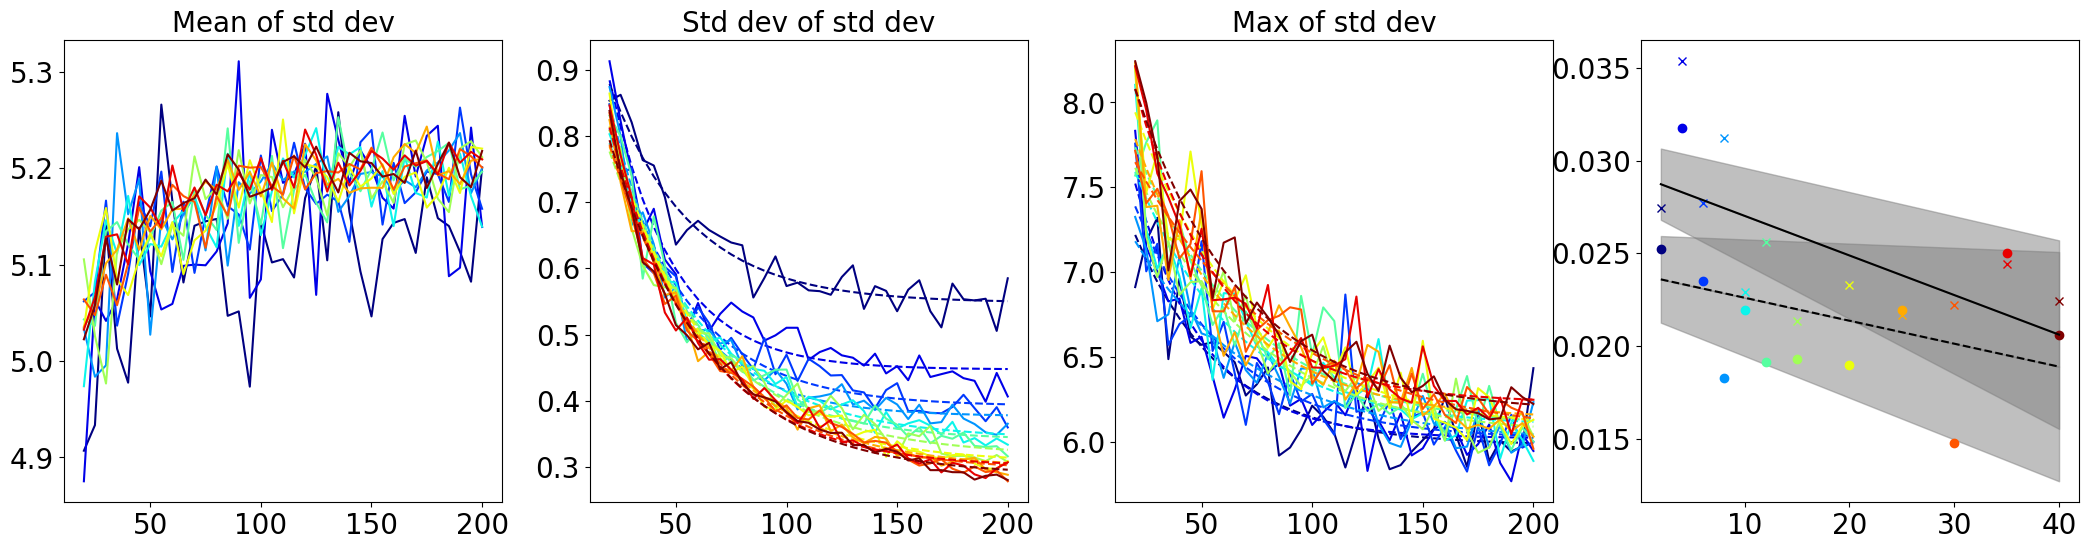

SIGMA =  0.3
params std/ max  [5.3641 0.07   1.9003] [64.4993  0.1131 19.1208]
params std/ max  [1.8213 0.0212 1.382 ] [ 7.0402  0.0228 18.8364]
params std/ max  [2.0263 0.0246 1.3026] [ 5.536   0.0202 19.1735]
params std/ max  [2.1865 0.0232 1.1583] [5.58920e+00 1.47000e-02 1.88507e+01]
params std/ max  [1.858  0.0198 1.0733] [5.41500e+00 9.70000e-03 1.81025e+01]
params std/ max  [2.2424 0.024  1.0948] [ 8.883   0.0271 19.4327]
params std/ max  [2.6964 0.0256 1.0473] [ 9.202   0.0215 19.1298]
params std/ max  [2.4188 0.0231 0.9942] [6.69560e+00 1.86000e-02 1.92014e+01]
params std/ max  [2.5469 0.0237 0.9791] [ 7.7913  0.0225 19.5141]
params std/ max  [2.2786 0.022  0.9411] [5.71350e+00 1.82000e-02 1.93842e+01]
params std/ max  [2.3407 0.0214 0.9243] [7.99130e+00 1.60000e-02 1.89889e+01]
params std/ max  [2.409  0.0217 0.9144] [8.38490e+00 1.87000e-02 1.93185e+01]
-0.0004325890305947322 0.00031373591206866494 0.0341499133903419 0.006617646515487145
-0.0008398722482725329 0.000631934615

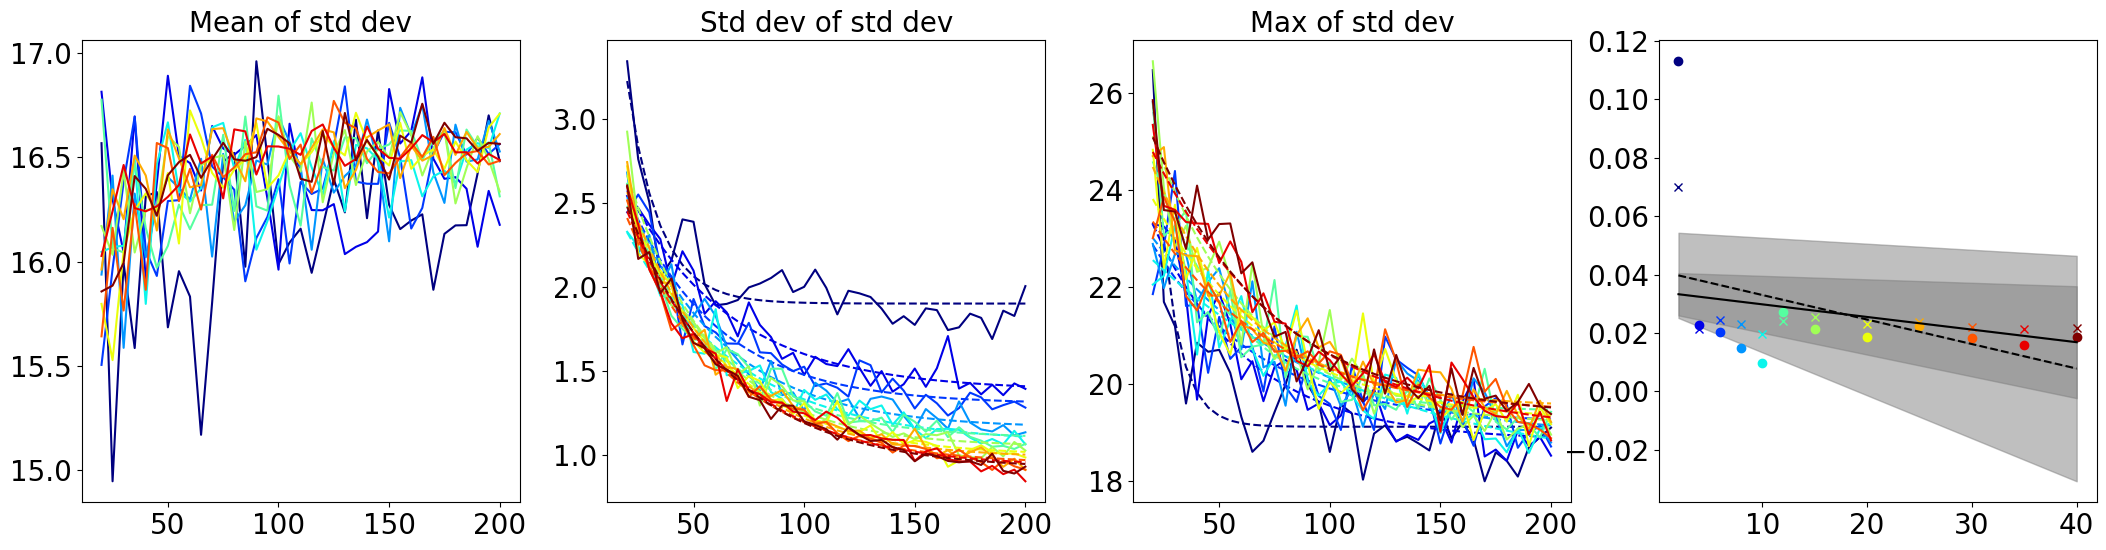

SIGMA =  0.5
params std/ max  [2.1446 0.0253 3.0341] [9.28990e+00 2.41000e-02 3.08553e+01]
params std/ max  [3.8204 0.0379 2.4188] [1.22089e+01 2.91000e-02 3.15074e+01]
params std/ max  [2.9635 0.0248 2.0263] [1.05034e+01 2.06000e-02 3.10587e+01]
params std/ max  [3.0224 0.0261 1.8766] [13.6872  0.0346 31.9758]
params std/ max  [3.065  0.0252 1.7474] [9.2394e+00 1.4900e-02 3.0927e+01]
params std/ max  [3.2878 0.0263 1.6878] [1.14511e+01 2.48000e-02 3.18553e+01]
params std/ max  [3.3884 0.0261 1.5956] [1.23703e+01 2.52000e-02 3.15951e+01]
params std/ max  [3.5328 0.0258 1.5148] [18.2062  0.0375 32.3732]
params std/ max  [3.066  0.0218 1.4214] [1.03918e+01 1.58000e-02 3.14487e+01]
params std/ max  [3.2686 0.0213 1.3562] [1.10384e+01 1.88000e-02 3.19382e+01]
params std/ max  [3.3233 0.0232 1.3569] [1.16633e+01 1.98000e-02 3.16752e+01]
params std/ max  [3.4662 0.0226 1.3144] [1.43370e+01 2.47000e-02 3.21422e+01]
-0.0001991568580437253 8.603840030288274e-05 0.02897014895715644 0.00181481211

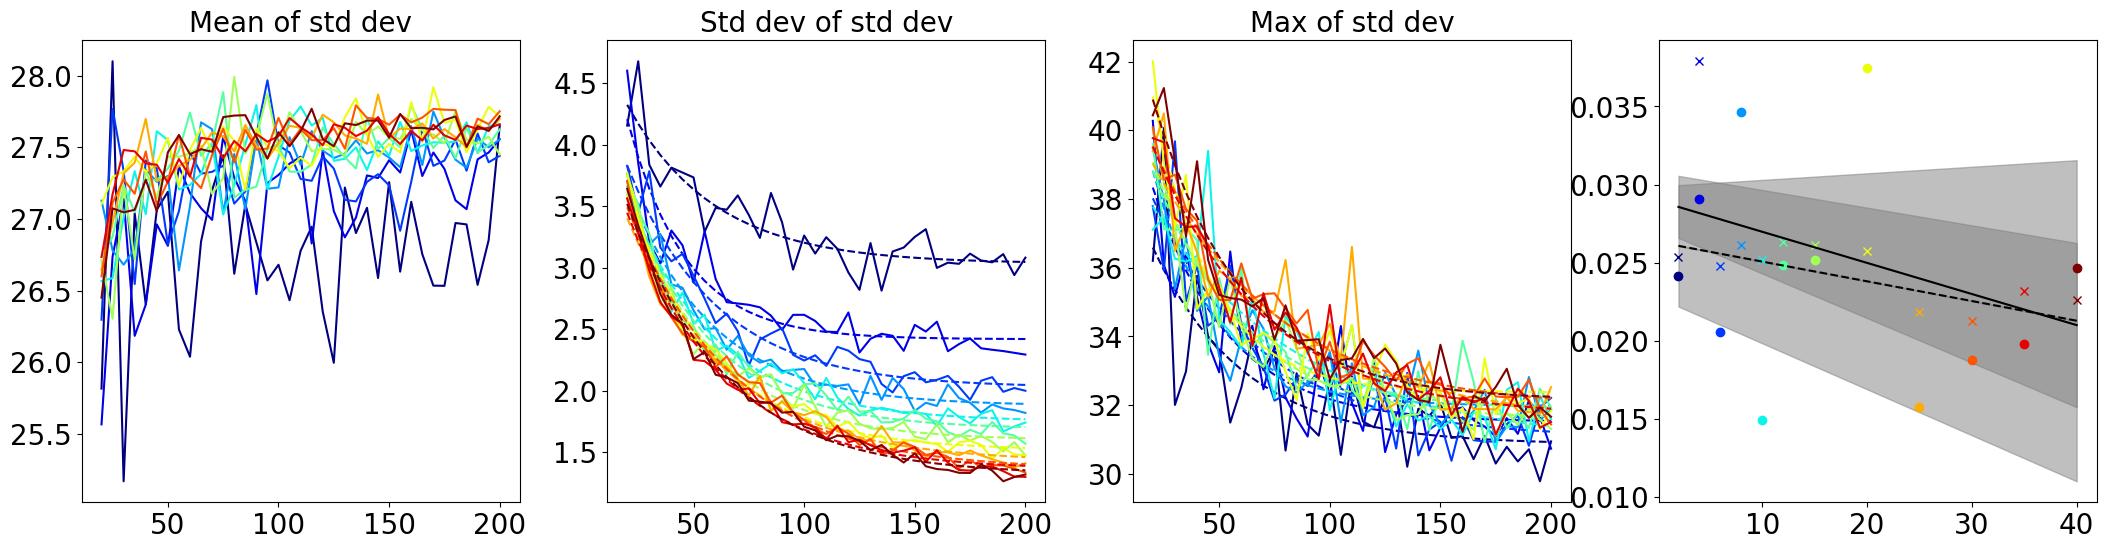

In [71]:
############# DETERMINE M
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

cmap = plt.cm.get_cmap("jet")

sigma_array = [0.1, 0.3, 0.5]
duration = np.array([2, 4, 6, 8, 10, 12, 15, 20, 25, 30, 35, 40])
p = coords[3]

ls=["solid", "dashed"]

def fitfunc(x, a, b, c):
    return c + a*np.exp(-b*x)

def fitfunclin(x, a, b):
    return a*x + b


for si in range(len(sigma_array)):

    print("SIGMA = ", sigma_array[si])

    fig, ax = plt.subplots(1,4, figsize=(26,6))

    p0list = []
    p1list = []

    for di, dur in enumerate(duration):
        time = np.arange(0,dur, dt)
        col = cmap(di/(len(duration)-1))

        model.params.sigma_ou = sigma_array[si]
        model.params.duration = dur * 100.
        setinitstate(model, data["D"]["init_state"])

        model.params["ext_exc_current"] = zero_control[:,0,:]
        model.params["ext_inh_current"] = zero_control[:,0,:]
        model.params.mue_ext_mean = p[0]
        model.params.mui_ext_mean = p[1]
        model.run()

        meanstd = []
        maxstd = []
        stdstd = []

        M_arr = []

        M = 20
        while True:
            allstates = np.zeros((M, model.rates_exc.shape[0], model.rates_exc.shape[1]))

            for m in range(M):
                model.run()
                allstates[m] = model.rates_exc[:,:]
                #plt.plot(time, model.rates_exc[0,:], linewidth=1, alpha=0.5, zorder=-1)

            mean = np.mean(allstates, axis=0)
            std = np.sqrt(np.var(allstates, axis=0))

            #plt.plot(time, mean[0], color="black", linewidth=1, zorder=2)
            #plt.fill_between(time, mean[0], mean[0]+std[0], color="black", alpha=0.3, zorder=1)
            #plt.fill_between(time, mean[0], mean[0]-std[0], color="black", alpha=0.3, zorder=1)
            #plt.show()

            meanstd.append(np.mean(std[0]))
            stdstd.append(np.std(std[0]))
            maxstd.append(np.amax(std[0]))
            M_arr.append(M)

            #print("M = {}". format(M))

            M += 2

            if M > 200: break

        meanstd = np.array(meanstd)
        stdstd = np.array(stdstd)
        maxstd = np.array(maxstd)
        M_arr = np.array(M_arr)

        ax[0].set_title("Mean of std dev")
        ax[1].set_title("Std dev of std dev")
        ax[2].set_title("Max of std dev")
        
        ax[0].plot(M_arr, meanstd, color=col, linestyle=ls[0])
        ax[1].plot(M_arr, stdstd, color=col, linestyle=ls[0])
        ax[2].plot(M_arr, maxstd, color=col, linestyle=ls[0])

        initp=[1., 0.01, 0.5]
        params0 = curve_fit(fitfunc, M_arr, stdstd, p0=initp, method="trf")[0]
        ff = fitfunc(M_arr, params0[0], params0[1], params0[2])
        ax[1].plot(M_arr, ff, color=col, linestyle=ls[1])

        initp=[1., 0.01, 5.]
        params1 = curve_fit(fitfunc, M_arr, maxstd, p0=initp, method="trf")[0]
        ff = fitfunc(M_arr, params1[0], params1[1], params1[2])
        ax[2].plot(M_arr, ff, color=col, linestyle=ls[1])

        p0list.append(params0[1])
        p1list.append(params1[1])

        ax[3].plot(dur, params0[1], color=col, marker="x")
        ax[3].plot(dur, params1[1], color=col, marker="o")

        print("params std/ max ", np.around(params0,4), np.around(params1,4))

    p0list = np.array(p0list)
    p1list = np.array(p1list)

    linpar, linparvar = curve_fit(fitfunclin, duration, p0list)
    ff = fitfunclin(duration, linpar[0], linpar[1])
    ffp = fitfunclin(duration, linpar[0]+np.sqrt(linparvar[0,0]), linpar[1]+np.sqrt(linparvar[1,1]))
    ffm = fitfunclin(duration, linpar[0]-np.sqrt(linparvar[0,0]), linpar[1]-np.sqrt(linparvar[1,1]))
    ax[3].plot(duration, ff, color="black", linestyle=ls[0])
    ax[3].fill_between(duration, ff, ffp, color="gray", alpha=0.5)
    ax[3].fill_between(duration, ff, ffm, color="gray", alpha=0.5)
    print(linpar[0], np.sqrt(linparvar[0,0]), linpar[1], np.sqrt(linparvar[1,1]))

    linpar, linparvar = curve_fit(fitfunclin, duration, p1list)
    ff = fitfunclin(duration, linpar[0], linpar[1])
    ffp = fitfunclin(duration, linpar[0]+np.sqrt(linparvar[0,0]), linpar[1]+np.sqrt(linparvar[1,1]))
    ffm = fitfunclin(duration, linpar[0]-np.sqrt(linparvar[0,0]), linpar[1]-np.sqrt(linparvar[1,1]))
    ax[3].plot(duration, ff, color="black", linestyle=ls[1])
    ax[3].fill_between(duration, ff, ffp, color="gray", alpha=0.5)
    ax[3].fill_between(duration, ff, ffm, color="gray", alpha=0.5)
    print(linpar[0], np.sqrt(linparvar[0,0]), linpar[1], np.sqrt(linparvar[1,1]))

    plt.show()

SIGMA =  0.1
SIGMA =  0.3
SIGMA =  0.5
SIGMA =  0.7


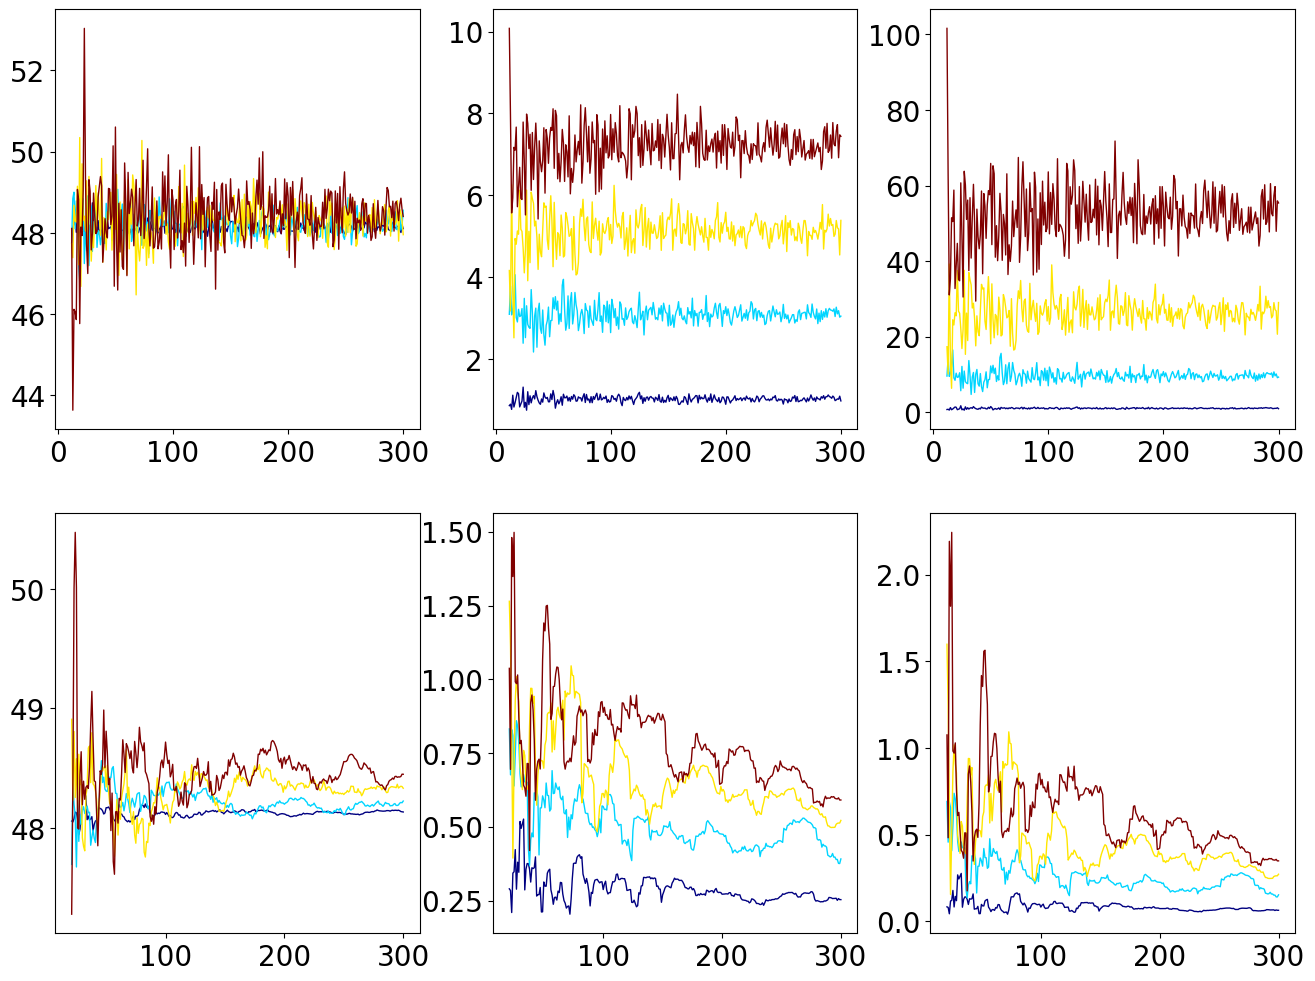

In [117]:
############# DETERMINE M
import math

duration = 1

fig, ax = plt.subplots(2,3, figsize=(16,12))
sigma_array = [0.1, 0.3, 0.5, 0.7]

for si in range(len(sigma_array)):

    print("SIGMA = ", sigma_array[si])
    col = cmap(si/(len(sigma_array)-1))

    p0list = []
    p1list = []

    time = np.arange(0,duration, dt)

    model.params.sigma_ou = sigma_array[si]
    model.params.duration = duration
    setinitstate(model, data["D"]["init_state"])

    model.params["ext_exc_current"] = zero_control[:,0,:]
    model.params["ext_inh_current"] = zero_control[:,0,:]
    model.params.mue_ext_mean = p[0]
    model.params.mui_ext_mean = p[1]
    model.run()

    meanlist = []
    stdlist = []
    varlist = []
    M_arr = []
    mean_sliding = []
    std_sliding = []
    var_sliding = []

    M_min = 12
    Mslidelim = 20

    M = M_min
    while True:
        allstates = np.zeros((M))

        for m in range(M):
            model.run()
            allstates[m] = model.rates_exc[0,-1]
            #plt.plot(time, model.rates_exc[0,:], linewidth=1, alpha=0.5, zorder=-1)


        meanlist.append(np.mean(allstates))
        stdlist.append(np.sqrt(np.var(allstates)))
        varlist.append(np.var(allstates))
        M_arr.append(M)

        if M > Mslidelim:
            M_slide = math.ceil(M/10)
            mean_sliding.append(np.mean(meanlist[-M_slide:]))
            std_sliding.append(np.sqrt(np.std(meanlist[-M_slide:])))
            var_sliding.append(np.std(meanlist[-M_slide:]))

        M += 1

        if M > 300: break

    meanlist = np.array(meanlist)
    stdlist = np.array(stdlist)
    M_arr = np.array(M_arr)

    ax[0,0].plot(M_arr, meanlist, color=col, linestyle=ls[0], linewidth=1)
    ax[0,1].plot(M_arr, stdlist, color=col, linestyle=ls[0], linewidth=1)
    ax[0,2].plot(M_arr, varlist, color=col, linestyle=ls[0], linewidth=1)

    ax[1,0].plot(M_arr[Mslidelim-M_min+1:], mean_sliding, color=col, linestyle=ls[0], linewidth=1)
    ax[1,1].plot(M_arr[Mslidelim-M_min+1:], std_sliding, color=col, linestyle=ls[0], linewidth=1)
    ax[1,2].plot(M_arr[Mslidelim-M_min+1:], var_sliding, color=col, linestyle=ls[0], linewidth=1)

plt.show()

In [221]:
def det_M(initialized_model, sigma_min_max, limit=1e-3, plot=True):
    
    model = copy.deepcopy(initialized_model)
    model.params.duration = 0.5

    sigma_array = np.linspace(sigma_min_max[0], sigma_min_max[1], 100)
    fitparams = [None for x in range(len(sigma_array))]

    for si in range(len(sigma_array)):

        model.params.sigma_ou = sigma_array[si]
        model.run()

        allstates = []
        meanstates = []
        varstates = []
        fitparams[si] = []
        
        m = 1

        while True:
            model.run()
            allstates.append(model[model.output_vars[0]][0,-1])
            meanstates.append(np.mean(allstates))
            varstates.append(np.var(allstates))
            
            if m >= 3:
                p, var = np.polyfit(np.arange(1,m+1, 1), meanstates, 1, cov=True)
                fitparams[si].append( np.sqrt(var[0,0]) )
                
                if fitparams[si][-1] < limit:
                    break
                
            m += 1

    Mvals = np.zeros((len(fitparams)))
    for si in range(len(sigma_array)):
        Mvals[si] = len(fitparams[si])

    p = np.polyfit(sigma_array, Mvals, 1)

    if plot:
        plt.plot(sigma_array, Mvals, color="black")
        plt.plot(sigma_array, p[0]*sigma_array + p[1], color="red", linestyle="--")
        plt.show()

    return p

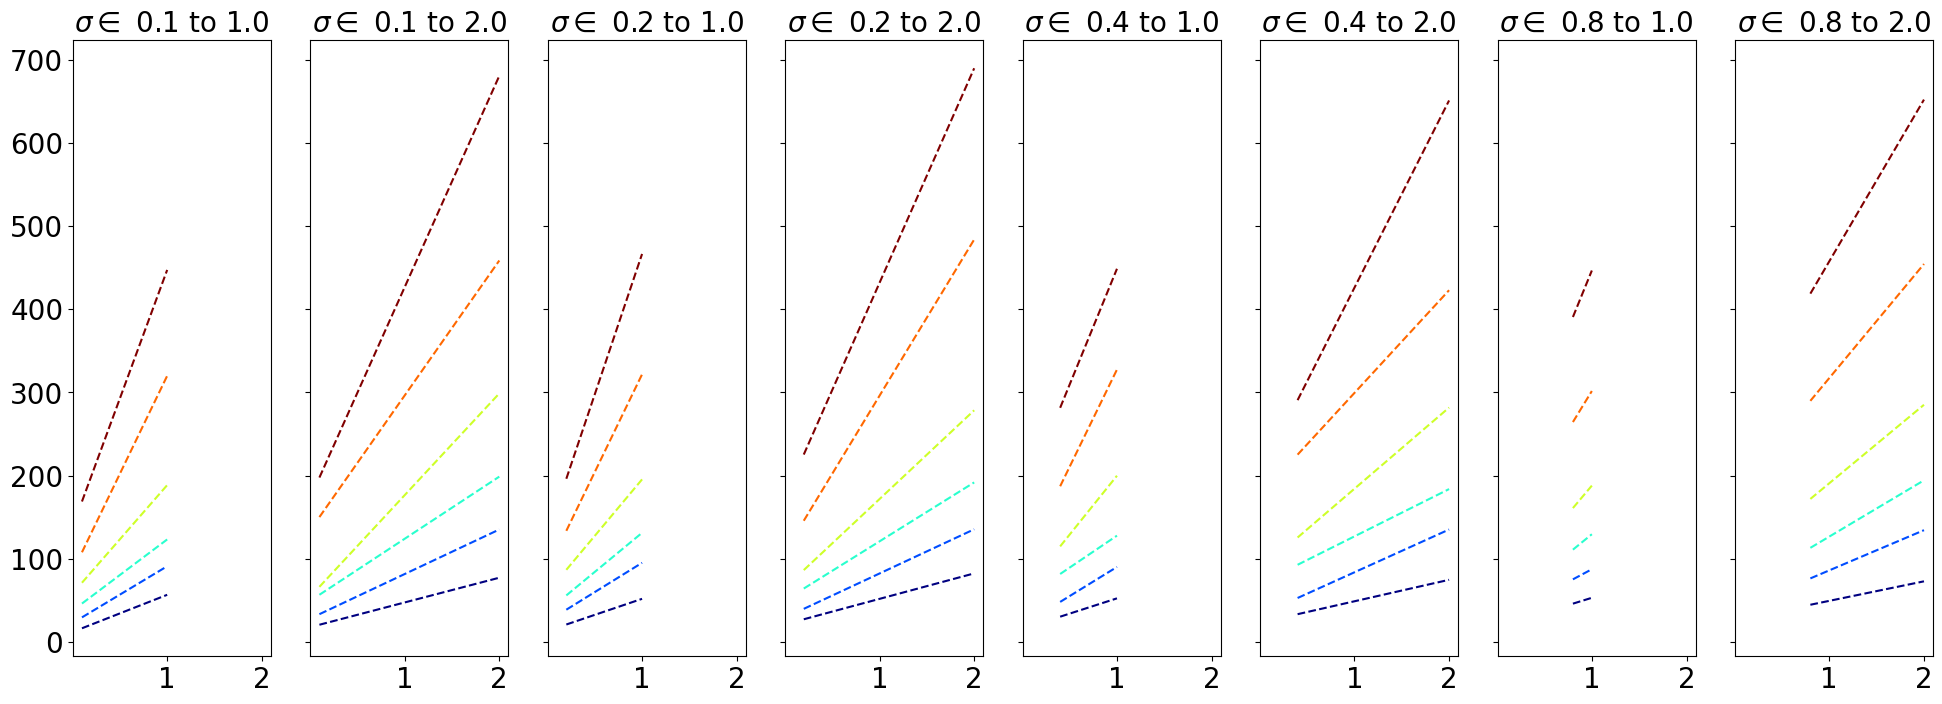

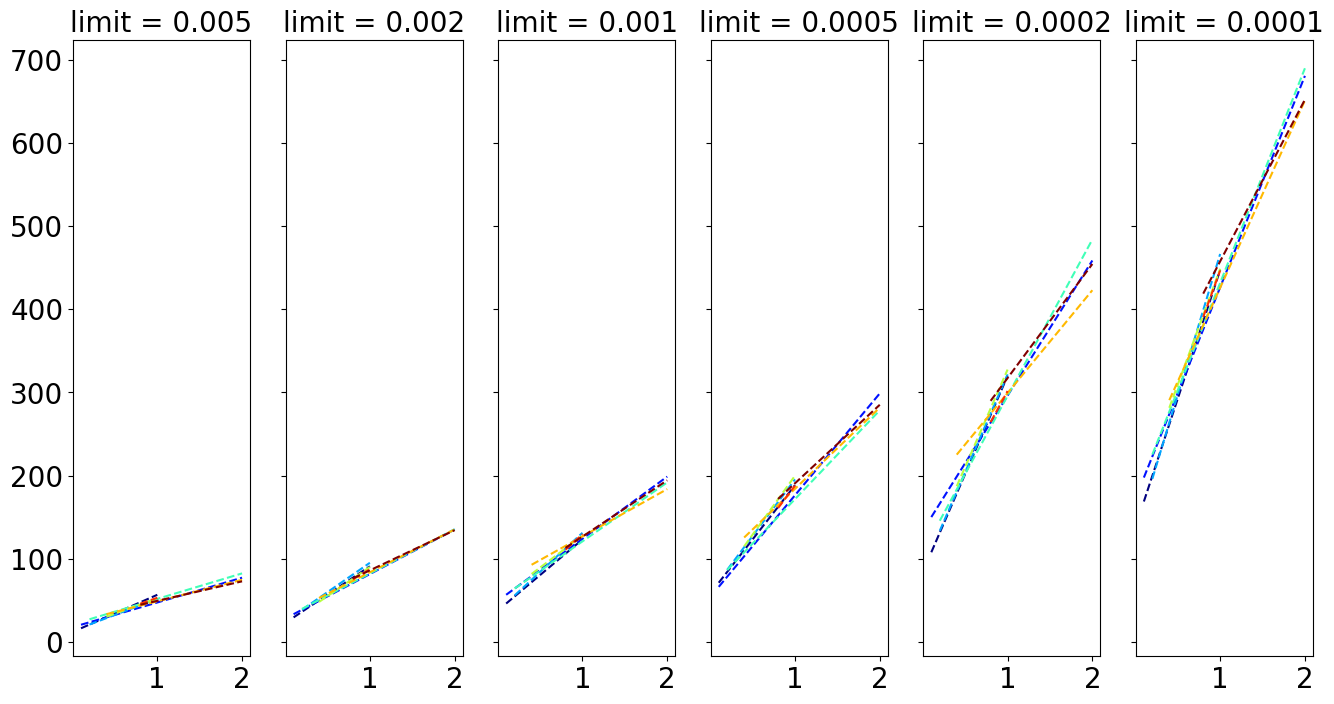

In [236]:
ranges = [[0.1, 1.], [0.1, 2.], [0.2, 1.], [0.2, 2.], [0.4, 1.], [0.4, 2.], [0.8, 1.], [0.8, 2.]]
limits = [5* 1e-3, 2*1e-3, 1e-3, 5*1e-4, 2*1e-4, 1e-4]

fig1, ax1 = plt.subplots(1, len(ranges), figsize=(24,8), sharex=True, sharey=True)
fig2, ax2 = plt.subplots(1, len(limits), figsize=(16,8), sharex=True, sharey=True)

fitpars = np.zeros(( len(ranges), len(limits), 2 ))

for i,r in enumerate(ranges):
    col2 = cmap(i/(len(ranges)-1))
    ax1[i].set_title(r"$\sigma \in $ "+ str(r[0])+ " to "+ str(r[1]))

    for j,l in enumerate(limits):
        ax2[j].set_title("limit = " + str(l))

        col1 = cmap(j/(len(limits)-1))

        fitpars[i,j,0], fitpars[i,j,1] = det_M(model, r, limit=l, plot=False)
        sigma_array = np.arange(0,2.1,0.1)
        ax1[i].plot(sigma_array, fitpars[i,j,0]*sigma_array + fitpars[i,j,1], color=col1, linestyle="--")
        ax2[j].plot(sigma_array, fitpars[i,j,0]*sigma_array + fitpars[i,j,1], color=col2, linestyle="--")

plt.show()

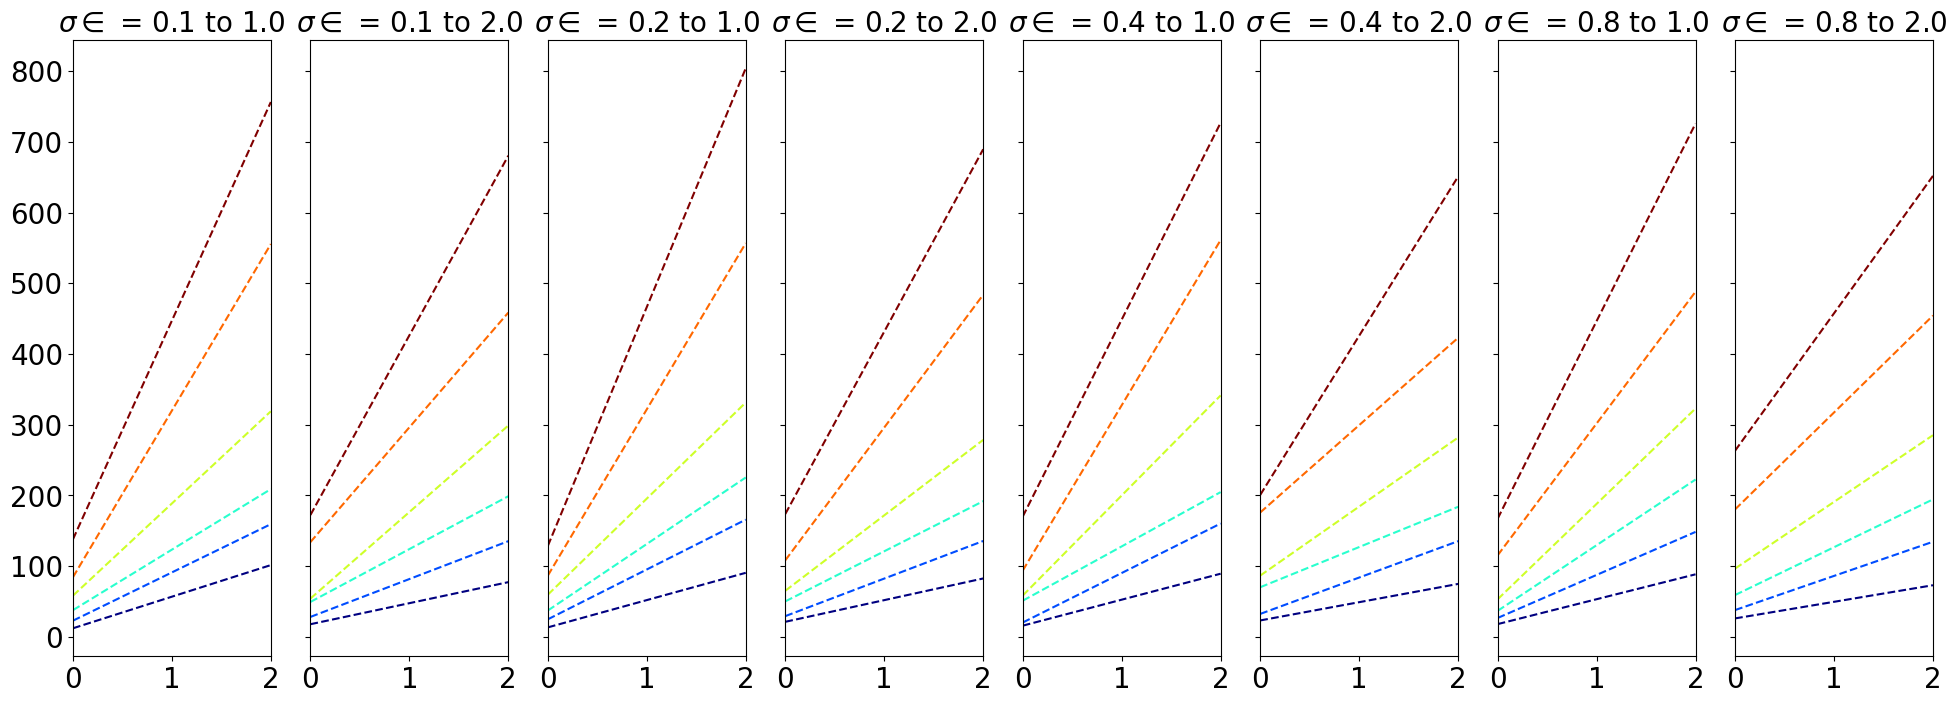

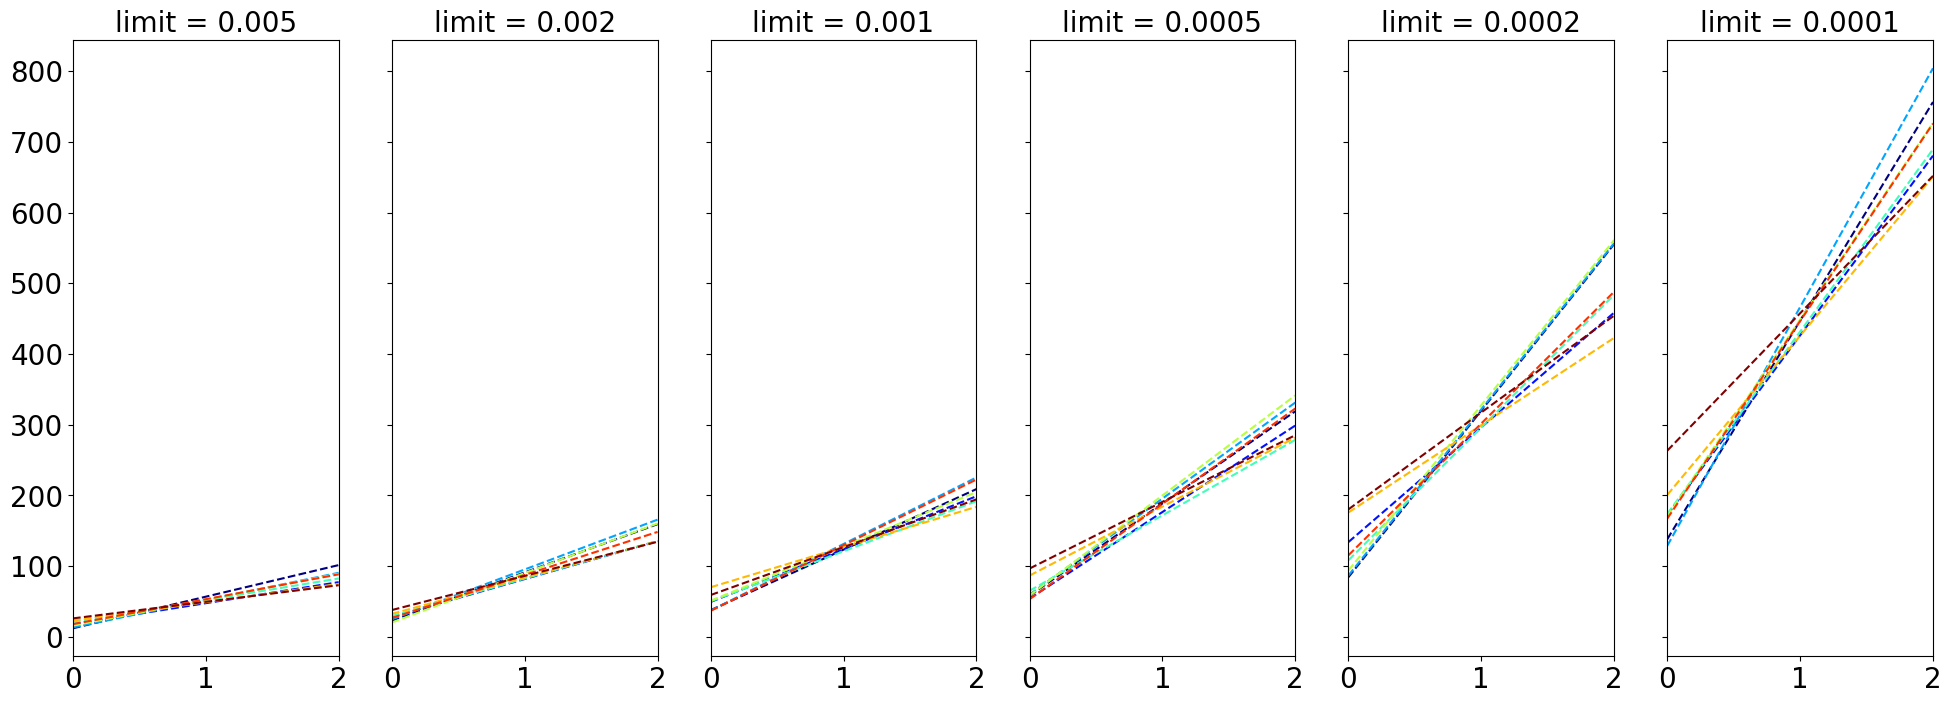

In [237]:
fig1, ax1 = plt.subplots(1, len(ranges), figsize=(24,8), sharex=True, sharey=True)
fig2, ax2 = plt.subplots(1, len(limits), figsize=(24,8), sharex=True, sharey=True)

for i,r in enumerate(ranges):
    col2 = cmap(i/(len(ranges)-1))
    ax1[i].set_title(r"$\sigma \in $ = "+ str(r[0])+ " to "+ str(r[1]))

    for j,l in enumerate(limits):
        ax2[j].set_title("limit = " + str(l))

        col1 = cmap(j/(len(limits)-1))
        sigma_array = np.arange(0,2.1,0.1)
        ax1[i].plot(sigma_array, fitpars[i,j,0]*sigma_array + fitpars[i,j,1], color=col1, linestyle="--")
        ax2[j].plot(sigma_array, fitpars[i,j,0]*sigma_array + fitpars[i,j,1], color=col2, linestyle="--")

ax1[0].set_xlim(0,2)
ax2[0].set_xlim(0,2)

plt.show()

SIGMA =  0.02
SIGMA =  0.06
SIGMA =  0.09999999999999999
SIGMA =  0.13999999999999999
SIGMA =  0.17999999999999997
SIGMA =  0.21999999999999995
SIGMA =  0.25999999999999995
SIGMA =  0.3
SIGMA =  0.33999999999999997
SIGMA =  0.37999999999999995
SIGMA =  0.41999999999999993
SIGMA =  0.45999999999999996
SIGMA =  0.49999999999999994
SIGMA =  0.5399999999999999
SIGMA =  0.58
SIGMA =  0.6199999999999999
SIGMA =  0.6599999999999999
SIGMA =  0.7
SIGMA =  0.7399999999999999
SIGMA =  0.7799999999999999
SIGMA =  0.8199999999999998
SIGMA =  0.8599999999999999
SIGMA =  0.8999999999999999
SIGMA =  0.9399999999999998
SIGMA =  0.9799999999999999


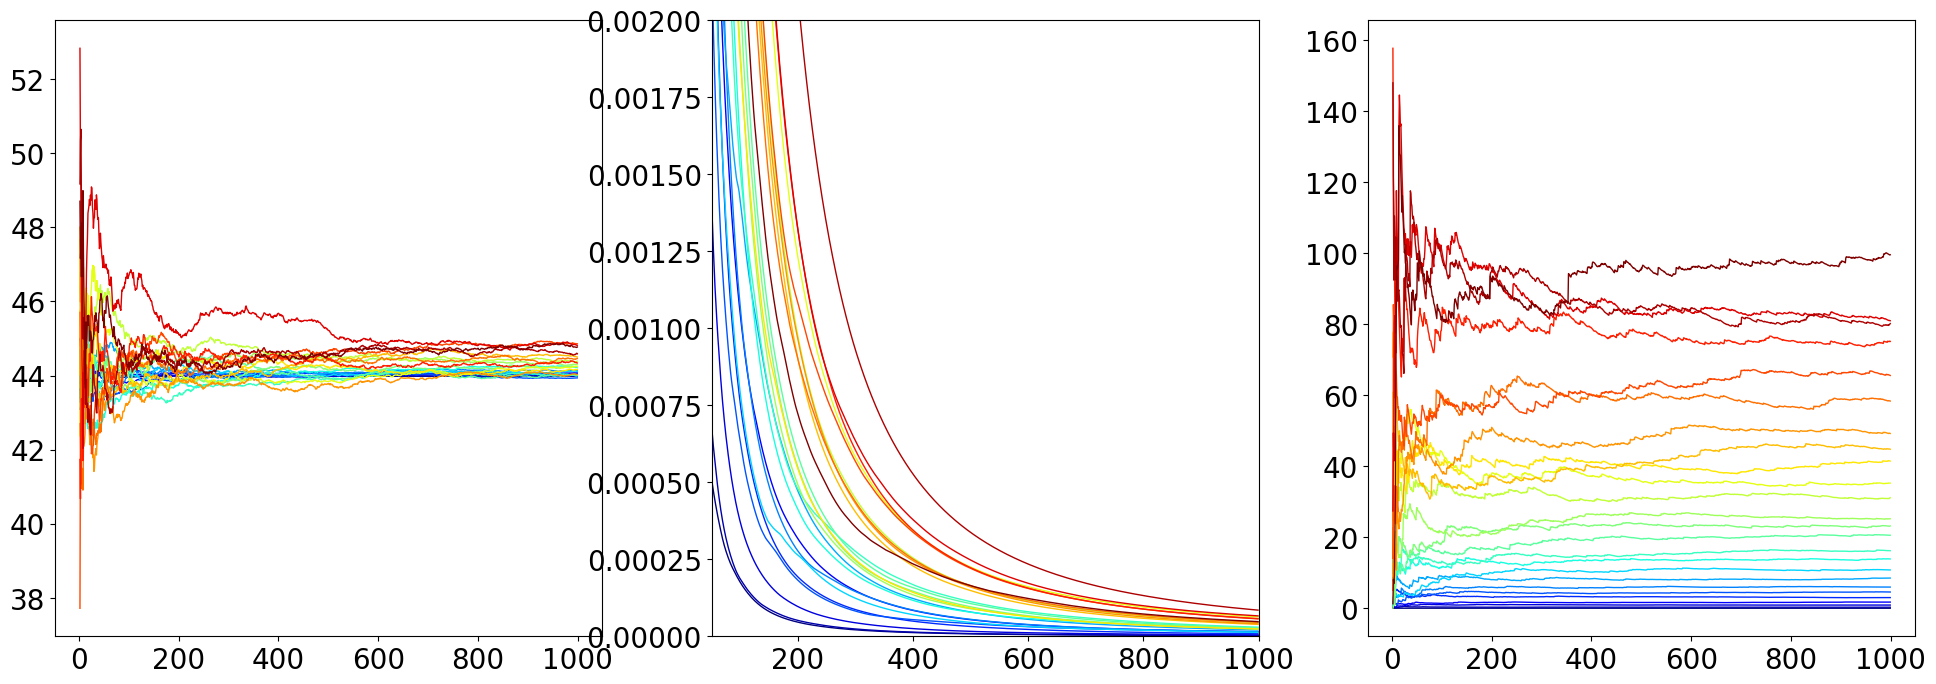

[32, 41, 60, 103, 87, 77, 104, 130, 89, 127, 132, 153, 148, 140, 198, 224, 143, 190, 197, 188, 212, 231, 231, 289, 167]


In [190]:
############# DETERMINE M
import math

duration = 1

fig, ax = plt.subplots(1,3, figsize=(24,8))
sigma_array = np.arange(0.02, 1.01, 0.04)

Mfinal = []

limparam = 1e-3
Mmin = 2
Mmax = 1000

fitparams = [None for x in range(len(sigma_array))]

for si in range(len(sigma_array)):

    print("SIGMA = ", sigma_array[si])
    col = cmap(si/(len(sigma_array)-1))

    model.params.sigma_ou = sigma_array[si]
    model.params.duration = duration
    setinitstate(model, data["D"]["init_state"])

    model.params["ext_exc_current"] = zero_control[:,0,:]
    model.params["ext_inh_current"] = zero_control[:,0,:]
    model.params.mue_ext_mean = p[0]
    model.params.mui_ext_mean = p[1]
    model.run()


    allstates = np.zeros((Mmax))
    meanstates = np.zeros((Mmax))
    varstates = np.zeros((Mmax))
    fitparams[si] = []
    
    lim = True

    for m in range(Mmax):
        model.run()
        allstates[m] = model.rates_exc[0,-1]
        meanstates[m] = np.mean(allstates[:m+1])
        varstates[m] = np.var(allstates[:m+1])
        
        if m > Mmin:
            p, var = curve_fit(fitfunclin, np.arange(0,m+1, 1), meanstates[:m+1])
            fitparams[si].append( np.sqrt(var[0,0]) )
            
            if fitparams[si][-1] < limparam and lim:
                #print("final M = ", m)
                Mfinal.append(m)
                lim = False

    #print("M within = ", mwithin)
    ax[1].plot(range(Mmin+1, Mmax), fitparams[si], color=col, linestyle=ls[0], linewidth=1)
    ax[0].plot(range(Mmin, Mmax), meanstates[Mmin:], color=col, linestyle=ls[0], linewidth=1)
    ax[2].plot(range(Mmin, Mmax), varstates[Mmin:], color=col, linestyle=ls[0], linewidth=1)


ax[1].set_ylim(0, 0.002)
ax[1].set_xlim(50, Mmax)

plt.show()

print(Mfinal)

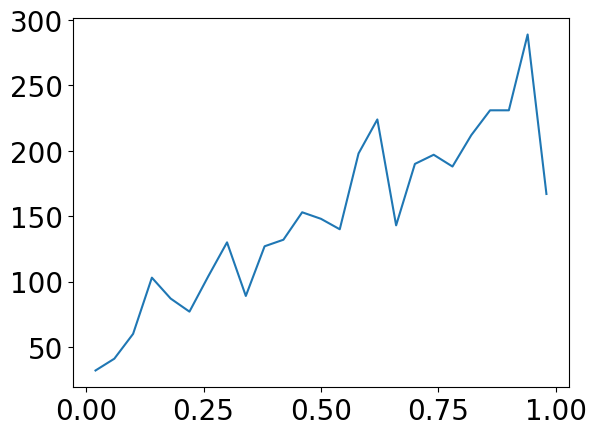

[32, 41, 60, 103, 87, 77, 104, 130, 89, 127, 132, 153, 148, 140, 198, 224, 143, 190, 197, 188, 212, 231, 231, 289, 167]


In [191]:
plt.plot(sigma_array, Mfinal)
plt.show()
print(Mfinal)

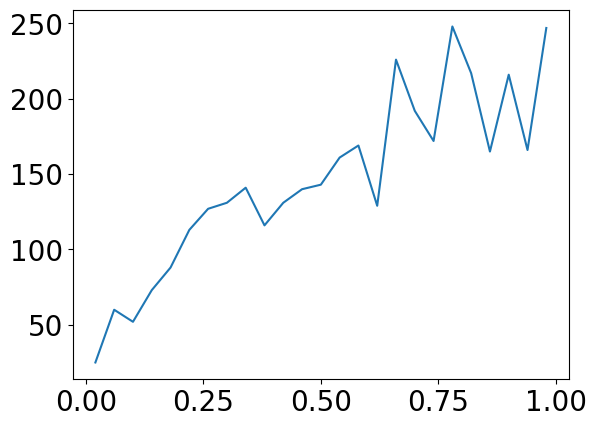

[25, 60, 52, 73, 88, 113, 127, 131, 141, 116, 131, 140, 143, 161, 169, 129, 226, 192, 172, 248, 217, 165, 216, 166, 247]


In [189]:
plt.plot(sigma_array, Mfinal)
plt.show()
print(Mfinal)

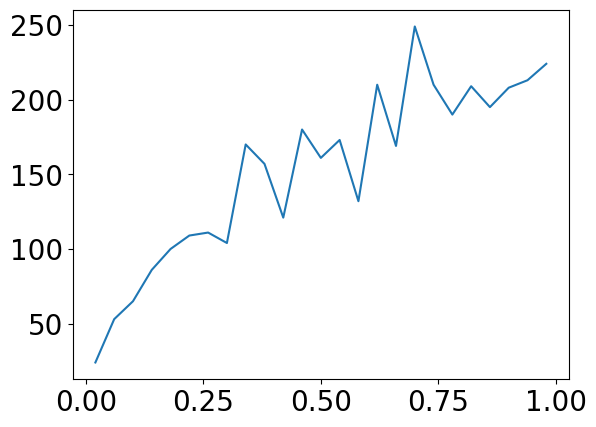

[24, 53, 65, 86, 100, 109, 111, 104, 170, 157, 121, 180, 161, 173, 132, 210, 169, 249, 210, 190, 209, 195, 208, 213, 224]


In [187]:
plt.plot(sigma_array, Mfinal)
plt.show()
print(Mfinal)